In [17]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.interpolate import interp1d
from scipy.spatial import distance
from tqdm import tqdm

In [2]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

In [4]:
# # 데이터 증강 함수 정의
# def augment_sequence(sequence, factor=0.2):
#     time_warped = []
#     for landmark in sequence:
#         x = np.arange(len(landmark))
#         f = interp1d(x, landmark, kind='linear', axis=0)
#         x_new = np.linspace(0, len(landmark) - 1, num=int(len(landmark) * (1 + factor)))
#         time_warped.append(f(x_new))
#     return np.array(time_warped)

In [5]:
# 바운딩 박스 비율 클래스 정의 함수
def bbox_ratio_class(ratio):
    if ratio < 0.7:
        return 0  # Normal 가능성 높은 class
    else:
        return 1  # Danger or Fall 가능성 높은 class

# YOLO xy 비율 계산 함수
def calculate_yolo_xy_ratio(frame):
    bbox = frame.get('bbox', None)
    if bbox and (bbox['x2'] - bbox['x1']) != 0:
        yolo_xy_ratio = round((bbox['y2'] - bbox['y1']) / (bbox['x2'] - bbox['x1']), 3)
    else:
        yolo_xy_ratio = 0.0
    return yolo_xy_ratio

In [6]:
# 머리 및 상체 속도 계산 함수 (시퀀스 평균값 사용)
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints.get(f'landmark_0', {}).get('x', 0.0), keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        l = np.array([keypoints.get(f'landmark_11', {}).get('x', 0.0), keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        r = np.array([keypoints.get(f'landmark_12', {}).get('x', 0.0), keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 이전 프레임의 좌표
        prev_h = np.array([prev_keypoints.get(f'landmark_0', {}).get('x', 0.0), prev_keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        prev_l = np.array([prev_keypoints.get(f'landmark_11', {}).get('x', 0.0), prev_keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        prev_r = np.array([prev_keypoints.get(f'landmark_12', {}).get('x', 0.0), prev_keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 현재 프레임과 이전 프레임의 상체 중심
        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        # 유클리드 거리 계산 (6프레임당 일정하므로 속력이라 봐도 무방함)
        dist_new = distance.euclidean(center_new, center_prev)
        speeds.append(dist_new)

    # 평균 속력 계산
    if speeds:
        return sum(speeds) / len(speeds)
    else:
        return 0.0

In [7]:
# 데이터셋 클래스 정의
# 현재 input은 mediapipe의 관절 좌표값 22개 + YOLO xy ratio + bbox_ratio_class + 머리/상체 속도 => 25개
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3, input_config='full'):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.input_config = input_config

        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            with open(json_file, 'r') as f:
                data = json.load(f)

            frames = list(data['pose_data'].values())

            for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                sequence = frames[i:i + self.sequence_length]
                landmarks = []

                # YOLO xy ratio 및 바운딩 박스 클래스는 시퀀스마다 1개씩만 추가
                yolo_xy_ratio = calculate_yolo_xy_ratio(sequence[-1])  # 마지막 프레임 기준으로 계산
                ratio_class = bbox_ratio_class(yolo_xy_ratio)
                head_torso_speed = calculate_head_upper_body_speed(sequence)

                for j, frame in enumerate(sequence):
                    frame_landmarks = []
                    if frame is not None:
                        if self.input_config in ['full', 'mediapipe']:
                            for landmark in LANDMARKS:
                                landmark_data = frame.get(f'landmark_{landmark}', None)
                                if landmark_data:
                                    frame_landmarks.extend([
                                        round(landmark_data['x'], 3),  # 소수점 세 자리로 반올림
                                        round(landmark_data['y'], 3)
                                    ])
                                else:
                                    frame_landmarks.extend([0.0, 0.0])

                        if self.input_config in ['full', 'simplified']:
                            # YOLO xy ratio, 바운딩 박스 클래스, 머리/상체 속도 추가 (시퀀스 단위로 동일 값 사용)
                            frame_landmarks.append(yolo_xy_ratio)
                            frame_landmarks.append(ratio_class)
                            frame_landmarks.append(head_torso_speed)
                    
                    landmarks.append(frame_landmarks)

                # 데이터 증강 없이 원래 데이터를 사용
                all_landmarks.extend(landmarks)

                # 레이블 재정의
                if sequence[-1]['class'] == 'Normal':
                    label = 0  # 비낙상
                elif sequence[-1]['class'] == 'Danger':
                    label = 1  # 낙상 위험
                elif sequence[-1]['class'] == 'Fall':
                    label = 2  # 완전 낙상

                self.sequences.append(landmarks)
                self.labels.append(label)

        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)

        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [8]:
# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

In [9]:
# 검증 및 테스트 데이터셋 로드 경로
train_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Train'
valid_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Val'
test_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Test'

# 각 데이터 폴더에서 JSON 파일 목록 생성
train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
valid_json_files = [os.path.join(valid_json_folder, f) for f in os.listdir(valid_json_folder) if f.endswith('.json')]
test_json_files = [os.path.join(test_json_folder, f) for f in os.listdir(test_json_folder) if f.endswith('.json')]

# 데이터셋 생성 (입력 데이터 설정에 따라)
train_full_dataset = FallSequenceDataset(train_json_files, input_config='full')
valid_full_dataset = FallSequenceDataset(valid_json_files, input_config='full')
test_full_dataset = FallSequenceDataset(test_json_files, input_config='full')

train_simplified_dataset = FallSequenceDataset(train_json_files, input_config='simplified')
valid_simplified_dataset = FallSequenceDataset(valid_json_files, input_config='simplified')
test_simplified_dataset = FallSequenceDataset(test_json_files, input_config='simplified')

train_mediapipe_dataset = FallSequenceDataset(train_json_files, input_config='mediapipe')
valid_mediapipe_dataset = FallSequenceDataset(valid_json_files, input_config='mediapipe')
test_mediapipe_dataset = FallSequenceDataset(test_json_files, input_config='mediapipe')

# 데이터 로더 생성
train_loader_full = DataLoader(train_full_dataset, batch_size=32, shuffle=True)
valid_loader_full = DataLoader(valid_full_dataset, batch_size=32, shuffle=False)
test_loader_full = DataLoader(test_full_dataset, batch_size=32, shuffle=False)

train_loader_simplified = DataLoader(train_simplified_dataset, batch_size=32, shuffle=True)
valid_loader_simplified = DataLoader(valid_simplified_dataset, batch_size=32, shuffle=False)
test_loader_simplified = DataLoader(test_simplified_dataset, batch_size=32, shuffle=False)

train_loader_mediapipe = DataLoader(train_mediapipe_dataset, batch_size=32, shuffle=True)
valid_loader_mediapipe = DataLoader(valid_mediapipe_dataset, batch_size=32, shuffle=False)
test_loader_mediapipe = DataLoader(test_mediapipe_dataset, batch_size=32, shuffle=False)

Processing JSON files: 100%|██████████| 397/397 [00:01<00:00, 289.87it/s]


In [10]:
# 클래스 가중치 계산 및 손실 함수 정의 (훈련 데이터셋 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(train_full_dataset.labels), y=train_full_dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 준비
def create_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence[0])  # 시퀀스 내의 각 프레임에서 입력의 길이를 가져옴
        return FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 파라미터 설정
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

In [110]:
# 학습 루프
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_001_full.pt', train_full_dataset, 0.001),
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_0001_full.pt', train_full_dataset, 0.0001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_0001_simplified.pt', train_simplified_dataset, 0.0001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_0001_mediapipe.pt', train_mediapipe_dataset, 0.0001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{train_loader.dataset.input_config}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_gru_001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1972/1972 [00:05<00:00, 394.33it/s]


Epoch [1/500], Train Loss: 0.4403
Epoch [1/500], Valid Loss: 0.3921


Epoch 2/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.65it/s]


Epoch [2/500], Train Loss: 0.3942
Epoch [2/500], Valid Loss: 0.3697


Epoch 3/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.82it/s]


Epoch [3/500], Train Loss: 0.3691
Epoch [3/500], Valid Loss: 0.3645


Epoch 4/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.31it/s]


Epoch [4/500], Train Loss: 0.3470
Epoch [4/500], Valid Loss: 0.3493


Epoch 5/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.18it/s]


Epoch [5/500], Train Loss: 0.3275
Epoch [5/500], Valid Loss: 0.3284


Epoch 6/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.04it/s]


Epoch [6/500], Train Loss: 0.3137
Epoch [6/500], Valid Loss: 0.3145


Epoch 7/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.36it/s]


Epoch [7/500], Train Loss: 0.3029
Epoch [7/500], Valid Loss: 0.3279


Epoch 8/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.05it/s]


Epoch [8/500], Train Loss: 0.2898
Epoch [8/500], Valid Loss: 0.2923


Epoch 9/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.54it/s]


Epoch [9/500], Train Loss: 0.2779
Epoch [9/500], Valid Loss: 0.2827


Epoch 10/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.75it/s]


Epoch [10/500], Train Loss: 0.2640
Epoch [10/500], Valid Loss: 0.2677


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.17it/s]


Epoch [11/500], Train Loss: 0.2509
Epoch [11/500], Valid Loss: 0.2763


Epoch 12/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.23it/s]


Epoch [12/500], Train Loss: 0.2357
Epoch [12/500], Valid Loss: 0.2495


Epoch 13/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.72it/s]


Epoch [13/500], Train Loss: 0.2263
Epoch [13/500], Valid Loss: 0.2408


Epoch 14/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.81it/s]


Epoch [14/500], Train Loss: 0.2114
Epoch [14/500], Valid Loss: 0.2363


Epoch 15/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.42it/s]


Epoch [15/500], Train Loss: 0.1965
Epoch [15/500], Valid Loss: 0.2272


Epoch 16/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.72it/s]


Epoch [16/500], Train Loss: 0.1841
Epoch [16/500], Valid Loss: 0.2148


Epoch 17/500: 100%|██████████| 1972/1972 [00:05<00:00, 368.30it/s]


Epoch [17/500], Train Loss: 0.1719
Epoch [17/500], Valid Loss: 0.2081


Epoch 18/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.65it/s]


Epoch [18/500], Train Loss: 0.1587
Epoch [18/500], Valid Loss: 0.1964


Epoch 19/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.49it/s]


Epoch [19/500], Train Loss: 0.1474
Epoch [19/500], Valid Loss: 0.1897


Epoch 20/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.16it/s]


Epoch [20/500], Train Loss: 0.1365
Epoch [20/500], Valid Loss: 0.1870


Epoch 21/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.40it/s]


Epoch [21/500], Train Loss: 0.1249
Epoch [21/500], Valid Loss: 0.1727


Epoch 22/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.78it/s]


Epoch [22/500], Train Loss: 0.1166
Epoch [22/500], Valid Loss: 0.1736


Epoch 23/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.43it/s]


Epoch [23/500], Train Loss: 0.1049
Epoch [23/500], Valid Loss: 0.1747


Epoch 24/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.75it/s]


Epoch [24/500], Train Loss: 0.0973
Epoch [24/500], Valid Loss: 0.1854


Epoch 25/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.06it/s]


Epoch [25/500], Train Loss: 0.0887
Epoch [25/500], Valid Loss: 0.1812


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.34it/s]


Epoch [26/500], Train Loss: 0.0857
Epoch [26/500], Valid Loss: 0.1699


Epoch 27/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.49it/s]


Epoch [27/500], Train Loss: 0.0795
Epoch [27/500], Valid Loss: 0.1736


Epoch 28/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.30it/s]


Epoch [28/500], Train Loss: 0.0757
Epoch [28/500], Valid Loss: 0.1746


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.10it/s]


Epoch [29/500], Train Loss: 0.0683
Epoch [29/500], Valid Loss: 0.1719


Epoch 30/500: 100%|██████████| 1972/1972 [00:05<00:00, 363.98it/s]


Epoch [30/500], Train Loss: 0.0655
Epoch [30/500], Valid Loss: 0.1798


Epoch 31/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.91it/s]


Epoch [31/500], Train Loss: 0.0634
Epoch [31/500], Valid Loss: 0.1692


Epoch 32/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.57it/s]


Epoch [32/500], Train Loss: 0.0562
Epoch [32/500], Valid Loss: 0.1814


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.56it/s]


Epoch [33/500], Train Loss: 0.0558
Epoch [33/500], Valid Loss: 0.1797


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.75it/s]


Epoch [34/500], Train Loss: 0.0515
Epoch [34/500], Valid Loss: 0.1868


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.77it/s]


Epoch [35/500], Train Loss: 0.0482
Epoch [35/500], Valid Loss: 0.1962


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.49it/s]


Epoch [36/500], Train Loss: 0.0506
Epoch [36/500], Valid Loss: 0.1726


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.65it/s]


Epoch [37/500], Train Loss: 0.0471
Epoch [37/500], Valid Loss: 0.1827


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.05it/s]


Epoch [38/500], Train Loss: 0.0297
Epoch [38/500], Valid Loss: 0.1620


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.20it/s]


Epoch [39/500], Train Loss: 0.0145
Epoch [39/500], Valid Loss: 0.1652


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.51it/s]


Epoch [40/500], Train Loss: 0.0106
Epoch [40/500], Valid Loss: 0.1712


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.42it/s]


Epoch [41/500], Train Loss: 0.0084
Epoch [41/500], Valid Loss: 0.1730


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.66it/s]


Epoch [42/500], Train Loss: 0.0069
Epoch [42/500], Valid Loss: 0.1740


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.96it/s]


Epoch [43/500], Train Loss: 0.0057
Epoch [43/500], Valid Loss: 0.1783


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.30it/s]


Epoch [44/500], Train Loss: 0.0051
Epoch [44/500], Valid Loss: 0.1818


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.24it/s]


Epoch [45/500], Train Loss: 0.0039
Epoch [45/500], Valid Loss: 0.1814


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.05it/s]


Epoch [46/500], Train Loss: 0.0037
Epoch [46/500], Valid Loss: 0.1826


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.24it/s]


Epoch [47/500], Train Loss: 0.0035
Epoch [47/500], Valid Loss: 0.1829


Epoch 48/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.52it/s]


Epoch [48/500], Train Loss: 0.0034
Epoch [48/500], Valid Loss: 0.1847


Epoch 49/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.46it/s]


Epoch [49/500], Train Loss: 0.0034
Epoch [49/500], Valid Loss: 0.1845


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.99it/s]


Epoch [50/500], Train Loss: 0.0033
Epoch [50/500], Valid Loss: 0.1847


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.25it/s]


Epoch [51/500], Train Loss: 0.0032
Epoch [51/500], Valid Loss: 0.1849


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.36it/s]


Epoch [52/500], Train Loss: 0.0032
Epoch [52/500], Valid Loss: 0.1850


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.77it/s]


Epoch [53/500], Train Loss: 0.0031
Epoch [53/500], Valid Loss: 0.1851


Epoch 54/500: 100%|██████████| 1972/1972 [00:05<00:00, 394.14it/s]


Epoch [54/500], Train Loss: 0.0031
Epoch [54/500], Valid Loss: 0.1852


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.05it/s]


Epoch [55/500], Train Loss: 0.0032
Epoch [55/500], Valid Loss: 0.1853


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.19it/s]


Epoch [56/500], Train Loss: 0.0031
Epoch [56/500], Valid Loss: 0.1854


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.28it/s]


Epoch [57/500], Train Loss: 0.0031
Epoch [57/500], Valid Loss: 0.1854


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.81it/s]


Epoch [58/500], Train Loss: 0.0031
Epoch [58/500], Valid Loss: 0.1854


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.22it/s]


Epoch [59/500], Train Loss: 0.0031
Epoch [59/500], Valid Loss: 0.1854


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.13it/s]


Epoch [60/500], Train Loss: 0.0031
Epoch [60/500], Valid Loss: 0.1854


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.48it/s]


Epoch [61/500], Train Loss: 0.0031
Epoch [61/500], Valid Loss: 0.1854


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.37it/s]


Epoch [62/500], Train Loss: 0.0031
Epoch [62/500], Valid Loss: 0.1854


Epoch 63/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.00it/s]


Epoch [63/500], Train Loss: 0.0031
Epoch [63/500], Valid Loss: 0.1854


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.31it/s]


Epoch [64/500], Train Loss: 0.0031
Epoch [64/500], Valid Loss: 0.1854


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.22it/s]


Epoch [65/500], Train Loss: 0.0031
Epoch [65/500], Valid Loss: 0.1854


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.31it/s]


Epoch [66/500], Train Loss: 0.0031
Epoch [66/500], Valid Loss: 0.1854


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.95it/s]


Epoch [67/500], Train Loss: 0.0031
Epoch [67/500], Valid Loss: 0.1854


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.16it/s]


Epoch [68/500], Train Loss: 0.0031
Epoch [68/500], Valid Loss: 0.1854


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.93it/s]


Epoch [69/500], Train Loss: 0.0031
Epoch [69/500], Valid Loss: 0.1854


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.94it/s]


Epoch [70/500], Train Loss: 0.0031
Epoch [70/500], Valid Loss: 0.1854


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.09it/s]


Epoch [71/500], Train Loss: 0.0031
Epoch [71/500], Valid Loss: 0.1854


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.04it/s]


Epoch [72/500], Train Loss: 0.0031
Epoch [72/500], Valid Loss: 0.1854


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.39it/s]


Epoch [73/500], Train Loss: 0.0031
Epoch [73/500], Valid Loss: 0.1854


Epoch 74/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.70it/s]


Epoch [74/500], Train Loss: 0.0031
Epoch [74/500], Valid Loss: 0.1854


Epoch 75/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.67it/s]


Epoch [75/500], Train Loss: 0.0031
Epoch [75/500], Valid Loss: 0.1854


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.66it/s]


Epoch [76/500], Train Loss: 0.0031
Epoch [76/500], Valid Loss: 0.1854


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.12it/s]


Epoch [77/500], Train Loss: 0.0031
Epoch [77/500], Valid Loss: 0.1854


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.36it/s]


Epoch [78/500], Train Loss: 0.0031
Epoch [78/500], Valid Loss: 0.1854


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.68it/s]


Epoch [79/500], Train Loss: 0.0031
Epoch [79/500], Valid Loss: 0.1854


Epoch 80/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.65it/s]


Epoch [80/500], Train Loss: 0.0031
Epoch [80/500], Valid Loss: 0.1854


Epoch 81/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.06it/s]


Epoch [81/500], Train Loss: 0.0031
Epoch [81/500], Valid Loss: 0.1854


Epoch 82/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.95it/s]


Epoch [82/500], Train Loss: 0.0031
Epoch [82/500], Valid Loss: 0.1854


Epoch 83/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.01it/s]


Epoch [83/500], Train Loss: 0.0031
Epoch [83/500], Valid Loss: 0.1854


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.53it/s]


Epoch [84/500], Train Loss: 0.0031
Epoch [84/500], Valid Loss: 0.1854


Epoch 85/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.88it/s]


Epoch [85/500], Train Loss: 0.0031
Epoch [85/500], Valid Loss: 0.1854


Epoch 86/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.38it/s]


Epoch [86/500], Train Loss: 0.0031
Epoch [86/500], Valid Loss: 0.1854


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.95it/s]


Epoch [87/500], Train Loss: 0.0031
Epoch [87/500], Valid Loss: 0.1854


Epoch 88/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.17it/s]


Epoch [88/500], Train Loss: 0.0031
Epoch [88/500], Valid Loss: 0.1854
Early stopping
best_fall_detection_gru_0001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.19it/s]


Epoch [1/500], Train Loss: 0.5079
Epoch [1/500], Valid Loss: 0.4335


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.40it/s]


Epoch [2/500], Train Loss: 0.4216
Epoch [2/500], Valid Loss: 0.4153


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.00it/s]


Epoch [3/500], Train Loss: 0.4113
Epoch [3/500], Valid Loss: 0.4107


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.01it/s]


Epoch [4/500], Train Loss: 0.4034
Epoch [4/500], Valid Loss: 0.3974


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.54it/s]


Epoch [5/500], Train Loss: 0.3974
Epoch [5/500], Valid Loss: 0.3969


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.01it/s]


Epoch [6/500], Train Loss: 0.3919
Epoch [6/500], Valid Loss: 0.3907


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.72it/s]


Epoch [7/500], Train Loss: 0.3876
Epoch [7/500], Valid Loss: 0.3932


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.21it/s]


Epoch [8/500], Train Loss: 0.3851
Epoch [8/500], Valid Loss: 0.3831


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.98it/s]


Epoch [9/500], Train Loss: 0.3797
Epoch [9/500], Valid Loss: 0.3848


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.05it/s]


Epoch [10/500], Train Loss: 0.3781
Epoch [10/500], Valid Loss: 0.3797


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.29it/s]


Epoch [11/500], Train Loss: 0.3735
Epoch [11/500], Valid Loss: 0.3746


Epoch 12/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.12it/s]


Epoch [12/500], Train Loss: 0.3727
Epoch [12/500], Valid Loss: 0.3729


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.26it/s]


Epoch [13/500], Train Loss: 0.3677
Epoch [13/500], Valid Loss: 0.3780


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.62it/s]


Epoch [14/500], Train Loss: 0.3659
Epoch [14/500], Valid Loss: 0.3733


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.11it/s]


Epoch [15/500], Train Loss: 0.3619
Epoch [15/500], Valid Loss: 0.3720


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.04it/s]


Epoch [16/500], Train Loss: 0.3595
Epoch [16/500], Valid Loss: 0.3665


Epoch 17/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.01it/s]


Epoch [17/500], Train Loss: 0.3551
Epoch [17/500], Valid Loss: 0.3635


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.49it/s]


Epoch [18/500], Train Loss: 0.3549
Epoch [18/500], Valid Loss: 0.3593


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.57it/s]


Epoch [19/500], Train Loss: 0.3512
Epoch [19/500], Valid Loss: 0.3537


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.02it/s]


Epoch [20/500], Train Loss: 0.3481
Epoch [20/500], Valid Loss: 0.3565


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.75it/s]


Epoch [21/500], Train Loss: 0.3457
Epoch [21/500], Valid Loss: 0.3515


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.81it/s]


Epoch [22/500], Train Loss: 0.3438
Epoch [22/500], Valid Loss: 0.3492


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.42it/s]


Epoch [23/500], Train Loss: 0.3405
Epoch [23/500], Valid Loss: 0.3470


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.83it/s]


Epoch [24/500], Train Loss: 0.3379
Epoch [24/500], Valid Loss: 0.3494


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.85it/s]


Epoch [25/500], Train Loss: 0.3369
Epoch [25/500], Valid Loss: 0.3452


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.74it/s]


Epoch [26/500], Train Loss: 0.3335
Epoch [26/500], Valid Loss: 0.3460


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.96it/s]


Epoch [27/500], Train Loss: 0.3318
Epoch [27/500], Valid Loss: 0.3404


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.87it/s]


Epoch [28/500], Train Loss: 0.3297
Epoch [28/500], Valid Loss: 0.3356


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.25it/s]


Epoch [29/500], Train Loss: 0.3282
Epoch [29/500], Valid Loss: 0.3413


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.56it/s]


Epoch [30/500], Train Loss: 0.3258
Epoch [30/500], Valid Loss: 0.3323


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.59it/s]


Epoch [31/500], Train Loss: 0.3227
Epoch [31/500], Valid Loss: 0.3370


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.76it/s]


Epoch [32/500], Train Loss: 0.3200
Epoch [32/500], Valid Loss: 0.3269


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.69it/s]


Epoch [33/500], Train Loss: 0.3193
Epoch [33/500], Valid Loss: 0.3282


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.93it/s]


Epoch [34/500], Train Loss: 0.3161
Epoch [34/500], Valid Loss: 0.3280


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.30it/s]


Epoch [35/500], Train Loss: 0.3144
Epoch [35/500], Valid Loss: 0.3223


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.38it/s]


Epoch [36/500], Train Loss: 0.3120
Epoch [36/500], Valid Loss: 0.3306


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.54it/s]


Epoch [37/500], Train Loss: 0.3091
Epoch [37/500], Valid Loss: 0.3287


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.08it/s]


Epoch [38/500], Train Loss: 0.3077
Epoch [38/500], Valid Loss: 0.3226


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.78it/s]


Epoch [39/500], Train Loss: 0.3065
Epoch [39/500], Valid Loss: 0.3200


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.71it/s]


Epoch [40/500], Train Loss: 0.3048
Epoch [40/500], Valid Loss: 0.3295


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.96it/s]


Epoch [41/500], Train Loss: 0.3018
Epoch [41/500], Valid Loss: 0.3180


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.16it/s]


Epoch [42/500], Train Loss: 0.2979
Epoch [42/500], Valid Loss: 0.3184


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.13it/s]


Epoch [43/500], Train Loss: 0.2970
Epoch [43/500], Valid Loss: 0.3206


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.19it/s]


Epoch [44/500], Train Loss: 0.2962
Epoch [44/500], Valid Loss: 0.3156


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.60it/s]


Epoch [45/500], Train Loss: 0.2929
Epoch [45/500], Valid Loss: 0.3142


Epoch 46/500: 100%|██████████| 1972/1972 [00:06<00:00, 314.55it/s]


Epoch [46/500], Train Loss: 0.2909
Epoch [46/500], Valid Loss: 0.3151


Epoch 47/500: 100%|██████████| 1972/1972 [00:05<00:00, 368.43it/s]


Epoch [47/500], Train Loss: 0.2875
Epoch [47/500], Valid Loss: 0.3144


Epoch 48/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.69it/s]


Epoch [48/500], Train Loss: 0.2870
Epoch [48/500], Valid Loss: 0.3050


Epoch 49/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.22it/s]


Epoch [49/500], Train Loss: 0.2859
Epoch [49/500], Valid Loss: 0.3068


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.31it/s]


Epoch [50/500], Train Loss: 0.2840
Epoch [50/500], Valid Loss: 0.2961


Epoch 51/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.33it/s]


Epoch [51/500], Train Loss: 0.2821
Epoch [51/500], Valid Loss: 0.2983


Epoch 52/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.50it/s]


Epoch [52/500], Train Loss: 0.2790
Epoch [52/500], Valid Loss: 0.3003


Epoch 53/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.19it/s]


Epoch [53/500], Train Loss: 0.2781
Epoch [53/500], Valid Loss: 0.2939


Epoch 54/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.04it/s]


Epoch [54/500], Train Loss: 0.2755
Epoch [54/500], Valid Loss: 0.2998


Epoch 55/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.72it/s]


Epoch [55/500], Train Loss: 0.2744
Epoch [55/500], Valid Loss: 0.3000


Epoch 56/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.32it/s]


Epoch [56/500], Train Loss: 0.2721
Epoch [56/500], Valid Loss: 0.2921


Epoch 57/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.59it/s]


Epoch [57/500], Train Loss: 0.2712
Epoch [57/500], Valid Loss: 0.3038


Epoch 58/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.04it/s]


Epoch [58/500], Train Loss: 0.2691
Epoch [58/500], Valid Loss: 0.2957


Epoch 59/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.66it/s]


Epoch [59/500], Train Loss: 0.2688
Epoch [59/500], Valid Loss: 0.2927


Epoch 60/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.70it/s]


Epoch [60/500], Train Loss: 0.2666
Epoch [60/500], Valid Loss: 0.2886


Epoch 61/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.37it/s]


Epoch [61/500], Train Loss: 0.2638
Epoch [61/500], Valid Loss: 0.2832


Epoch 62/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.33it/s]


Epoch [62/500], Train Loss: 0.2629
Epoch [62/500], Valid Loss: 0.2931


Epoch 63/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.19it/s]


Epoch [63/500], Train Loss: 0.2609
Epoch [63/500], Valid Loss: 0.2856


Epoch 64/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.80it/s]


Epoch [64/500], Train Loss: 0.2596
Epoch [64/500], Valid Loss: 0.2783


Epoch 65/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.60it/s]


Epoch [65/500], Train Loss: 0.2556
Epoch [65/500], Valid Loss: 0.2790


Epoch 66/500: 100%|██████████| 1972/1972 [00:05<00:00, 394.18it/s]


Epoch [66/500], Train Loss: 0.2552
Epoch [66/500], Valid Loss: 0.2805


Epoch 67/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.29it/s]


Epoch [67/500], Train Loss: 0.2540
Epoch [67/500], Valid Loss: 0.2805


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.21it/s]


Epoch [68/500], Train Loss: 0.2524
Epoch [68/500], Valid Loss: 0.2817


Epoch 69/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.42it/s]


Epoch [69/500], Train Loss: 0.2492
Epoch [69/500], Valid Loss: 0.2798


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.80it/s]


Epoch [70/500], Train Loss: 0.2487
Epoch [70/500], Valid Loss: 0.2820


Epoch 71/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.54it/s]


Epoch [71/500], Train Loss: 0.2373
Epoch [71/500], Valid Loss: 0.2661


Epoch 72/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.60it/s]


Epoch [72/500], Train Loss: 0.2358
Epoch [72/500], Valid Loss: 0.2660


Epoch 73/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.79it/s]


Epoch [73/500], Train Loss: 0.2351
Epoch [73/500], Valid Loss: 0.2658


Epoch 74/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.46it/s]


Epoch [74/500], Train Loss: 0.2356
Epoch [74/500], Valid Loss: 0.2645


Epoch 75/500: 100%|██████████| 1972/1972 [00:05<00:00, 394.26it/s]


Epoch [75/500], Train Loss: 0.2349
Epoch [75/500], Valid Loss: 0.2676


Epoch 76/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.36it/s]


Epoch [76/500], Train Loss: 0.2341
Epoch [76/500], Valid Loss: 0.2670


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.05it/s]


Epoch [77/500], Train Loss: 0.2340
Epoch [77/500], Valid Loss: 0.2652


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.05it/s]


Epoch [78/500], Train Loss: 0.2340
Epoch [78/500], Valid Loss: 0.2652


Epoch 79/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.34it/s]


Epoch [79/500], Train Loss: 0.2336
Epoch [79/500], Valid Loss: 0.2635


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.68it/s]


Epoch [80/500], Train Loss: 0.2331
Epoch [80/500], Valid Loss: 0.2639


Epoch 81/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.97it/s]


Epoch [81/500], Train Loss: 0.2329
Epoch [81/500], Valid Loss: 0.2654


Epoch 82/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.02it/s]


Epoch [82/500], Train Loss: 0.2338
Epoch [82/500], Valid Loss: 0.2631


Epoch 83/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.76it/s]


Epoch [83/500], Train Loss: 0.2313
Epoch [83/500], Valid Loss: 0.2645


Epoch 84/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.32it/s]


Epoch [84/500], Train Loss: 0.2325
Epoch [84/500], Valid Loss: 0.2628


Epoch 85/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.26it/s]


Epoch [85/500], Train Loss: 0.2323
Epoch [85/500], Valid Loss: 0.2640


Epoch 86/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.77it/s]


Epoch [86/500], Train Loss: 0.2323
Epoch [86/500], Valid Loss: 0.2630


Epoch 87/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.91it/s]


Epoch [87/500], Train Loss: 0.2310
Epoch [87/500], Valid Loss: 0.2639


Epoch 88/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.97it/s]


Epoch [88/500], Train Loss: 0.2307
Epoch [88/500], Valid Loss: 0.2622


Epoch 89/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.89it/s]


Epoch [89/500], Train Loss: 0.2304
Epoch [89/500], Valid Loss: 0.2642


Epoch 90/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.06it/s]


Epoch [90/500], Train Loss: 0.2304
Epoch [90/500], Valid Loss: 0.2640


Epoch 91/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.47it/s]


Epoch [91/500], Train Loss: 0.2308
Epoch [91/500], Valid Loss: 0.2626


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.62it/s]


Epoch [92/500], Train Loss: 0.2306
Epoch [92/500], Valid Loss: 0.2631


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.32it/s]


Epoch [93/500], Train Loss: 0.2303
Epoch [93/500], Valid Loss: 0.2620


Epoch 94/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.36it/s]


Epoch [94/500], Train Loss: 0.2299
Epoch [94/500], Valid Loss: 0.2627


Epoch 95/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.29it/s]


Epoch [95/500], Train Loss: 0.2300
Epoch [95/500], Valid Loss: 0.2617


Epoch 96/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.69it/s]


Epoch [96/500], Train Loss: 0.2290
Epoch [96/500], Valid Loss: 0.2628


Epoch 97/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.04it/s]


Epoch [97/500], Train Loss: 0.2295
Epoch [97/500], Valid Loss: 0.2628


Epoch 98/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.74it/s]


Epoch [98/500], Train Loss: 0.2299
Epoch [98/500], Valid Loss: 0.2615


Epoch 99/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.64it/s]


Epoch [99/500], Train Loss: 0.2293
Epoch [99/500], Valid Loss: 0.2603


Epoch 100/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.58it/s]


Epoch [100/500], Train Loss: 0.2280
Epoch [100/500], Valid Loss: 0.2610


Epoch 101/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.68it/s]


Epoch [101/500], Train Loss: 0.2278
Epoch [101/500], Valid Loss: 0.2609


Epoch 102/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.61it/s]


Epoch [102/500], Train Loss: 0.2280
Epoch [102/500], Valid Loss: 0.2612


Epoch 103/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.16it/s]


Epoch [103/500], Train Loss: 0.2275
Epoch [103/500], Valid Loss: 0.2594


Epoch 104/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.67it/s]


Epoch [104/500], Train Loss: 0.2272
Epoch [104/500], Valid Loss: 0.2614


Epoch 105/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.55it/s]


Epoch [105/500], Train Loss: 0.2266
Epoch [105/500], Valid Loss: 0.2590


Epoch 106/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.43it/s]


Epoch [106/500], Train Loss: 0.2270
Epoch [106/500], Valid Loss: 0.2606


Epoch 107/500: 100%|██████████| 1972/1972 [00:05<00:00, 366.97it/s]


Epoch [107/500], Train Loss: 0.2264
Epoch [107/500], Valid Loss: 0.2605


Epoch 108/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.98it/s]


Epoch [108/500], Train Loss: 0.2276
Epoch [108/500], Valid Loss: 0.2603


Epoch 109/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.03it/s]


Epoch [109/500], Train Loss: 0.2271
Epoch [109/500], Valid Loss: 0.2593


Epoch 110/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.22it/s]


Epoch [110/500], Train Loss: 0.2269
Epoch [110/500], Valid Loss: 0.2587


Epoch 111/500: 100%|██████████| 1972/1972 [00:05<00:00, 372.12it/s]


Epoch [111/500], Train Loss: 0.2265
Epoch [111/500], Valid Loss: 0.2588


Epoch 112/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.63it/s]


Epoch [112/500], Train Loss: 0.2257
Epoch [112/500], Valid Loss: 0.2583


Epoch 113/500: 100%|██████████| 1972/1972 [00:05<00:00, 372.59it/s]


Epoch [113/500], Train Loss: 0.2255
Epoch [113/500], Valid Loss: 0.2582


Epoch 114/500: 100%|██████████| 1972/1972 [00:05<00:00, 370.88it/s]


Epoch [114/500], Train Loss: 0.2254
Epoch [114/500], Valid Loss: 0.2585


Epoch 115/500: 100%|██████████| 1972/1972 [00:05<00:00, 373.44it/s]


Epoch [115/500], Train Loss: 0.2246
Epoch [115/500], Valid Loss: 0.2581


Epoch 116/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.53it/s]


Epoch [116/500], Train Loss: 0.2245
Epoch [116/500], Valid Loss: 0.2573


Epoch 117/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.32it/s]


Epoch [117/500], Train Loss: 0.2245
Epoch [117/500], Valid Loss: 0.2577


Epoch 118/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.75it/s]


Epoch [118/500], Train Loss: 0.2252
Epoch [118/500], Valid Loss: 0.2562


Epoch 119/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.00it/s]


Epoch [119/500], Train Loss: 0.2238
Epoch [119/500], Valid Loss: 0.2569


Epoch 120/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.81it/s]


Epoch [120/500], Train Loss: 0.2248
Epoch [120/500], Valid Loss: 0.2577


Epoch 121/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.99it/s]


Epoch [121/500], Train Loss: 0.2244
Epoch [121/500], Valid Loss: 0.2573


Epoch 122/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.52it/s]


Epoch [122/500], Train Loss: 0.2234
Epoch [122/500], Valid Loss: 0.2558


Epoch 123/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.89it/s]


Epoch [123/500], Train Loss: 0.2231
Epoch [123/500], Valid Loss: 0.2561


Epoch 124/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.84it/s]


Epoch [124/500], Train Loss: 0.2229
Epoch [124/500], Valid Loss: 0.2567


Epoch 125/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.90it/s]


Epoch [125/500], Train Loss: 0.2232
Epoch [125/500], Valid Loss: 0.2561


Epoch 126/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.27it/s]


Epoch [126/500], Train Loss: 0.2227
Epoch [126/500], Valid Loss: 0.2565


Epoch 127/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.60it/s]


Epoch [127/500], Train Loss: 0.2226
Epoch [127/500], Valid Loss: 0.2555


Epoch 128/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.54it/s]


Epoch [128/500], Train Loss: 0.2221
Epoch [128/500], Valid Loss: 0.2573


Epoch 129/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.25it/s]


Epoch [129/500], Train Loss: 0.2220
Epoch [129/500], Valid Loss: 0.2575


Epoch 130/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.90it/s]


Epoch [130/500], Train Loss: 0.2228
Epoch [130/500], Valid Loss: 0.2560


Epoch 131/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.74it/s]


Epoch [131/500], Train Loss: 0.2213
Epoch [131/500], Valid Loss: 0.2558


Epoch 132/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.34it/s]


Epoch [132/500], Train Loss: 0.2214
Epoch [132/500], Valid Loss: 0.2539


Epoch 133/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.88it/s]


Epoch [133/500], Train Loss: 0.2213
Epoch [133/500], Valid Loss: 0.2552


Epoch 134/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.23it/s]


Epoch [134/500], Train Loss: 0.2225
Epoch [134/500], Valid Loss: 0.2535


Epoch 135/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.47it/s]


Epoch [135/500], Train Loss: 0.2205
Epoch [135/500], Valid Loss: 0.2541


Epoch 136/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.03it/s]


Epoch [136/500], Train Loss: 0.2206
Epoch [136/500], Valid Loss: 0.2553


Epoch 137/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.99it/s]


Epoch [137/500], Train Loss: 0.2200
Epoch [137/500], Valid Loss: 0.2536


Epoch 138/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.42it/s]


Epoch [138/500], Train Loss: 0.2206
Epoch [138/500], Valid Loss: 0.2534


Epoch 139/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.07it/s]


Epoch [139/500], Train Loss: 0.2206
Epoch [139/500], Valid Loss: 0.2547


Epoch 140/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.64it/s]


Epoch [140/500], Train Loss: 0.2196
Epoch [140/500], Valid Loss: 0.2530


Epoch 141/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.16it/s]


Epoch [141/500], Train Loss: 0.2196
Epoch [141/500], Valid Loss: 0.2528


Epoch 142/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.08it/s]


Epoch [142/500], Train Loss: 0.2192
Epoch [142/500], Valid Loss: 0.2540


Epoch 143/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.84it/s]


Epoch [143/500], Train Loss: 0.2200
Epoch [143/500], Valid Loss: 0.2532


Epoch 144/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.67it/s]


Epoch [144/500], Train Loss: 0.2188
Epoch [144/500], Valid Loss: 0.2514


Epoch 145/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.61it/s]


Epoch [145/500], Train Loss: 0.2186
Epoch [145/500], Valid Loss: 0.2524


Epoch 146/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.67it/s]


Epoch [146/500], Train Loss: 0.2187
Epoch [146/500], Valid Loss: 0.2514


Epoch 147/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.67it/s]


Epoch [147/500], Train Loss: 0.2183
Epoch [147/500], Valid Loss: 0.2528


Epoch 148/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.28it/s]


Epoch [148/500], Train Loss: 0.2179
Epoch [148/500], Valid Loss: 0.2520


Epoch 149/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.57it/s]


Epoch [149/500], Train Loss: 0.2183
Epoch [149/500], Valid Loss: 0.2517


Epoch 150/500: 100%|██████████| 1972/1972 [00:05<00:00, 373.54it/s]


Epoch [150/500], Train Loss: 0.2178
Epoch [150/500], Valid Loss: 0.2512


Epoch 151/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.98it/s]


Epoch [151/500], Train Loss: 0.2175
Epoch [151/500], Valid Loss: 0.2511


Epoch 152/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.69it/s]


Epoch [152/500], Train Loss: 0.2173
Epoch [152/500], Valid Loss: 0.2519


Epoch 153/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.56it/s]


Epoch [153/500], Train Loss: 0.2171
Epoch [153/500], Valid Loss: 0.2515


Epoch 154/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.70it/s]


Epoch [154/500], Train Loss: 0.2163
Epoch [154/500], Valid Loss: 0.2508


Epoch 155/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.97it/s]


Epoch [155/500], Train Loss: 0.2170
Epoch [155/500], Valid Loss: 0.2498


Epoch 156/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.64it/s]


Epoch [156/500], Train Loss: 0.2160
Epoch [156/500], Valid Loss: 0.2504


Epoch 157/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.78it/s]


Epoch [157/500], Train Loss: 0.2164
Epoch [157/500], Valid Loss: 0.2509


Epoch 158/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.97it/s]


Epoch [158/500], Train Loss: 0.2172
Epoch [158/500], Valid Loss: 0.2515


Epoch 159/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.46it/s]


Epoch [159/500], Train Loss: 0.2161
Epoch [159/500], Valid Loss: 0.2493


Epoch 160/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.58it/s]


Epoch [160/500], Train Loss: 0.2154
Epoch [160/500], Valid Loss: 0.2488


Epoch 161/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.56it/s]


Epoch [161/500], Train Loss: 0.2154
Epoch [161/500], Valid Loss: 0.2488


Epoch 162/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.95it/s]


Epoch [162/500], Train Loss: 0.2152
Epoch [162/500], Valid Loss: 0.2510


Epoch 163/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.22it/s]


Epoch [163/500], Train Loss: 0.2140
Epoch [163/500], Valid Loss: 0.2522


Epoch 164/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.71it/s]


Epoch [164/500], Train Loss: 0.2145
Epoch [164/500], Valid Loss: 0.2497


Epoch 165/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.24it/s]


Epoch [165/500], Train Loss: 0.2141
Epoch [165/500], Valid Loss: 0.2488


Epoch 166/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.63it/s]


Epoch [166/500], Train Loss: 0.2144
Epoch [166/500], Valid Loss: 0.2489


Epoch 167/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.41it/s]


Epoch [167/500], Train Loss: 0.2123
Epoch [167/500], Valid Loss: 0.2485


Epoch 168/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.53it/s]


Epoch [168/500], Train Loss: 0.2129
Epoch [168/500], Valid Loss: 0.2484


Epoch 169/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.67it/s]


Epoch [169/500], Train Loss: 0.2121
Epoch [169/500], Valid Loss: 0.2480


Epoch 170/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.33it/s]


Epoch [170/500], Train Loss: 0.2116
Epoch [170/500], Valid Loss: 0.2482


Epoch 171/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.31it/s]


Epoch [171/500], Train Loss: 0.2122
Epoch [171/500], Valid Loss: 0.2485


Epoch 172/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.06it/s]


Epoch [172/500], Train Loss: 0.2117
Epoch [172/500], Valid Loss: 0.2481


Epoch 173/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.18it/s]


Epoch [173/500], Train Loss: 0.2119
Epoch [173/500], Valid Loss: 0.2481


Epoch 174/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.34it/s]


Epoch [174/500], Train Loss: 0.2121
Epoch [174/500], Valid Loss: 0.2478


Epoch 175/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.68it/s]


Epoch [175/500], Train Loss: 0.2124
Epoch [175/500], Valid Loss: 0.2478


Epoch 176/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.07it/s]


Epoch [176/500], Train Loss: 0.2123
Epoch [176/500], Valid Loss: 0.2477


Epoch 177/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.10it/s]


Epoch [177/500], Train Loss: 0.2119
Epoch [177/500], Valid Loss: 0.2479


Epoch 178/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.39it/s]


Epoch [178/500], Train Loss: 0.2123
Epoch [178/500], Valid Loss: 0.2479


Epoch 179/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.42it/s]


Epoch [179/500], Train Loss: 0.2130
Epoch [179/500], Valid Loss: 0.2480


Epoch 180/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.13it/s]


Epoch [180/500], Train Loss: 0.2118
Epoch [180/500], Valid Loss: 0.2480


Epoch 181/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.71it/s]


Epoch [181/500], Train Loss: 0.2132
Epoch [181/500], Valid Loss: 0.2480


Epoch 182/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.58it/s]


Epoch [182/500], Train Loss: 0.2124
Epoch [182/500], Valid Loss: 0.2477


Epoch 183/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.72it/s]


Epoch [183/500], Train Loss: 0.2111
Epoch [183/500], Valid Loss: 0.2478


Epoch 184/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.35it/s]


Epoch [184/500], Train Loss: 0.2112
Epoch [184/500], Valid Loss: 0.2478


Epoch 185/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.63it/s]


Epoch [185/500], Train Loss: 0.2107
Epoch [185/500], Valid Loss: 0.2478


Epoch 186/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.47it/s]


Epoch [186/500], Train Loss: 0.2115
Epoch [186/500], Valid Loss: 0.2478


Epoch 187/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.05it/s]


Epoch [187/500], Train Loss: 0.2116
Epoch [187/500], Valid Loss: 0.2478


Epoch 188/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.40it/s]


Epoch [188/500], Train Loss: 0.2122
Epoch [188/500], Valid Loss: 0.2478


Epoch 189/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.34it/s]


Epoch [189/500], Train Loss: 0.2121
Epoch [189/500], Valid Loss: 0.2478


Epoch 190/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.48it/s]


Epoch [190/500], Train Loss: 0.2117
Epoch [190/500], Valid Loss: 0.2478


Epoch 191/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.48it/s]


Epoch [191/500], Train Loss: 0.2124
Epoch [191/500], Valid Loss: 0.2478


Epoch 192/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.83it/s]


Epoch [192/500], Train Loss: 0.2121
Epoch [192/500], Valid Loss: 0.2478


Epoch 193/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.90it/s]


Epoch [193/500], Train Loss: 0.2122
Epoch [193/500], Valid Loss: 0.2478


Epoch 194/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.90it/s]


Epoch [194/500], Train Loss: 0.2126
Epoch [194/500], Valid Loss: 0.2478


Epoch 195/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.00it/s]


Epoch [195/500], Train Loss: 0.2119
Epoch [195/500], Valid Loss: 0.2478


Epoch 196/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.13it/s]


Epoch [196/500], Train Loss: 0.2123
Epoch [196/500], Valid Loss: 0.2478


Epoch 197/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.00it/s]


Epoch [197/500], Train Loss: 0.2119
Epoch [197/500], Valid Loss: 0.2478


Epoch 198/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.31it/s]


Epoch [198/500], Train Loss: 0.2118
Epoch [198/500], Valid Loss: 0.2478


Epoch 199/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.05it/s]


Epoch [199/500], Train Loss: 0.2117
Epoch [199/500], Valid Loss: 0.2478


Epoch 200/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.53it/s]


Epoch [200/500], Train Loss: 0.2123
Epoch [200/500], Valid Loss: 0.2478


Epoch 201/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.20it/s]


Epoch [201/500], Train Loss: 0.2114
Epoch [201/500], Valid Loss: 0.2477


Epoch 202/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.02it/s]


Epoch [202/500], Train Loss: 0.2121
Epoch [202/500], Valid Loss: 0.2477


Epoch 203/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.43it/s]


Epoch [203/500], Train Loss: 0.2120
Epoch [203/500], Valid Loss: 0.2477


Epoch 204/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.86it/s]


Epoch [204/500], Train Loss: 0.2121
Epoch [204/500], Valid Loss: 0.2477


Epoch 205/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.25it/s]


Epoch [205/500], Train Loss: 0.2117
Epoch [205/500], Valid Loss: 0.2477


Epoch 206/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.09it/s]


Epoch [206/500], Train Loss: 0.2119
Epoch [206/500], Valid Loss: 0.2477


Epoch 207/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.36it/s]


Epoch [207/500], Train Loss: 0.2124
Epoch [207/500], Valid Loss: 0.2477


Epoch 208/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.31it/s]


Epoch [208/500], Train Loss: 0.2114
Epoch [208/500], Valid Loss: 0.2477


Epoch 209/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.11it/s]


Epoch [209/500], Train Loss: 0.2121
Epoch [209/500], Valid Loss: 0.2477


Epoch 210/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.42it/s]


Epoch [210/500], Train Loss: 0.2114
Epoch [210/500], Valid Loss: 0.2477


Epoch 211/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.82it/s]


Epoch [211/500], Train Loss: 0.2110
Epoch [211/500], Valid Loss: 0.2477


Epoch 212/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.92it/s]


Epoch [212/500], Train Loss: 0.2122
Epoch [212/500], Valid Loss: 0.2477


Epoch 213/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.58it/s]


Epoch [213/500], Train Loss: 0.2124
Epoch [213/500], Valid Loss: 0.2477


Epoch 214/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.47it/s]


Epoch [214/500], Train Loss: 0.2115
Epoch [214/500], Valid Loss: 0.2477


Epoch 215/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.32it/s]


Epoch [215/500], Train Loss: 0.2123
Epoch [215/500], Valid Loss: 0.2477


Epoch 216/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.40it/s]


Epoch [216/500], Train Loss: 0.2115
Epoch [216/500], Valid Loss: 0.2477


Epoch 217/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.93it/s]


Epoch [217/500], Train Loss: 0.2116
Epoch [217/500], Valid Loss: 0.2477


Epoch 218/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.41it/s]


Epoch [218/500], Train Loss: 0.2121
Epoch [218/500], Valid Loss: 0.2477


Epoch 219/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.16it/s]


Epoch [219/500], Train Loss: 0.2115
Epoch [219/500], Valid Loss: 0.2477


Epoch 220/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.54it/s]


Epoch [220/500], Train Loss: 0.2121
Epoch [220/500], Valid Loss: 0.2477


Epoch 221/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.54it/s]


Epoch [221/500], Train Loss: 0.2110
Epoch [221/500], Valid Loss: 0.2477


Epoch 222/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.13it/s]


Epoch [222/500], Train Loss: 0.2118
Epoch [222/500], Valid Loss: 0.2477


Epoch 223/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.79it/s]


Epoch [223/500], Train Loss: 0.2117
Epoch [223/500], Valid Loss: 0.2477


Epoch 224/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.99it/s]


Epoch [224/500], Train Loss: 0.2115
Epoch [224/500], Valid Loss: 0.2477


Epoch 225/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.03it/s]


Epoch [225/500], Train Loss: 0.2121
Epoch [225/500], Valid Loss: 0.2477


Epoch 226/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.79it/s]


Epoch [226/500], Train Loss: 0.2117
Epoch [226/500], Valid Loss: 0.2477


Epoch 227/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.11it/s]


Epoch [227/500], Train Loss: 0.2118
Epoch [227/500], Valid Loss: 0.2477


Epoch 228/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.38it/s]


Epoch [228/500], Train Loss: 0.2109
Epoch [228/500], Valid Loss: 0.2477


Epoch 229/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.45it/s]


Epoch [229/500], Train Loss: 0.2119
Epoch [229/500], Valid Loss: 0.2477


Epoch 230/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.28it/s]


Epoch [230/500], Train Loss: 0.2121
Epoch [230/500], Valid Loss: 0.2477


Epoch 231/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.05it/s]


Epoch [231/500], Train Loss: 0.2111
Epoch [231/500], Valid Loss: 0.2477


Epoch 232/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.62it/s]


Epoch [232/500], Train Loss: 0.2119
Epoch [232/500], Valid Loss: 0.2477


Epoch 233/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.72it/s]


Epoch [233/500], Train Loss: 0.2122
Epoch [233/500], Valid Loss: 0.2477


Epoch 234/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.56it/s]


Epoch [234/500], Train Loss: 0.2113
Epoch [234/500], Valid Loss: 0.2477


Epoch 235/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.09it/s]


Epoch [235/500], Train Loss: 0.2115
Epoch [235/500], Valid Loss: 0.2477


Epoch 236/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.37it/s]


Epoch [236/500], Train Loss: 0.2117
Epoch [236/500], Valid Loss: 0.2477


Epoch 237/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.26it/s]


Epoch [237/500], Train Loss: 0.2124
Epoch [237/500], Valid Loss: 0.2477


Epoch 238/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.90it/s]


Epoch [238/500], Train Loss: 0.2120
Epoch [238/500], Valid Loss: 0.2477


Epoch 239/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.44it/s]


Epoch [239/500], Train Loss: 0.2123
Epoch [239/500], Valid Loss: 0.2477


Epoch 240/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.20it/s]


Epoch [240/500], Train Loss: 0.2113
Epoch [240/500], Valid Loss: 0.2477


Epoch 241/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.60it/s]


Epoch [241/500], Train Loss: 0.2128
Epoch [241/500], Valid Loss: 0.2477


Epoch 242/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.66it/s]


Epoch [242/500], Train Loss: 0.2119
Epoch [242/500], Valid Loss: 0.2477


Epoch 243/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.92it/s]


Epoch [243/500], Train Loss: 0.2119
Epoch [243/500], Valid Loss: 0.2477


Epoch 244/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.80it/s]


Epoch [244/500], Train Loss: 0.2121
Epoch [244/500], Valid Loss: 0.2477


Epoch 245/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.20it/s]


Epoch [245/500], Train Loss: 0.2120
Epoch [245/500], Valid Loss: 0.2477


Epoch 246/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.98it/s]


Epoch [246/500], Train Loss: 0.2122
Epoch [246/500], Valid Loss: 0.2477


Epoch 247/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.93it/s]


Epoch [247/500], Train Loss: 0.2120
Epoch [247/500], Valid Loss: 0.2477


Epoch 248/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.60it/s]


Epoch [248/500], Train Loss: 0.2115
Epoch [248/500], Valid Loss: 0.2476


Epoch 249/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.60it/s]


Epoch [249/500], Train Loss: 0.2120
Epoch [249/500], Valid Loss: 0.2476


Epoch 250/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.31it/s]


Epoch [250/500], Train Loss: 0.2125
Epoch [250/500], Valid Loss: 0.2476


Epoch 251/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.35it/s]


Epoch [251/500], Train Loss: 0.2129
Epoch [251/500], Valid Loss: 0.2476


Epoch 252/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.89it/s]


Epoch [252/500], Train Loss: 0.2115
Epoch [252/500], Valid Loss: 0.2476


Epoch 253/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.08it/s]


Epoch [253/500], Train Loss: 0.2116
Epoch [253/500], Valid Loss: 0.2476


Epoch 254/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.34it/s]


Epoch [254/500], Train Loss: 0.2126
Epoch [254/500], Valid Loss: 0.2476


Epoch 255/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.32it/s]


Epoch [255/500], Train Loss: 0.2118
Epoch [255/500], Valid Loss: 0.2476


Epoch 256/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.57it/s]


Epoch [256/500], Train Loss: 0.2120
Epoch [256/500], Valid Loss: 0.2476


Epoch 257/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.99it/s]


Epoch [257/500], Train Loss: 0.2117
Epoch [257/500], Valid Loss: 0.2476


Epoch 258/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.15it/s]


Epoch [258/500], Train Loss: 0.2121
Epoch [258/500], Valid Loss: 0.2476


Epoch 259/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.69it/s]


Epoch [259/500], Train Loss: 0.2125
Epoch [259/500], Valid Loss: 0.2476


Epoch 260/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.14it/s]


Epoch [260/500], Train Loss: 0.2117
Epoch [260/500], Valid Loss: 0.2476


Epoch 261/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.47it/s]


Epoch [261/500], Train Loss: 0.2120
Epoch [261/500], Valid Loss: 0.2476


Epoch 262/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.53it/s]


Epoch [262/500], Train Loss: 0.2115
Epoch [262/500], Valid Loss: 0.2476


Epoch 263/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.98it/s]


Epoch [263/500], Train Loss: 0.2122
Epoch [263/500], Valid Loss: 0.2476


Epoch 264/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.25it/s]


Epoch [264/500], Train Loss: 0.2117
Epoch [264/500], Valid Loss: 0.2476


Epoch 265/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.23it/s]


Epoch [265/500], Train Loss: 0.2121
Epoch [265/500], Valid Loss: 0.2476


Epoch 266/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.49it/s]


Epoch [266/500], Train Loss: 0.2109
Epoch [266/500], Valid Loss: 0.2476


Epoch 267/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.35it/s]


Epoch [267/500], Train Loss: 0.2114
Epoch [267/500], Valid Loss: 0.2476


Epoch 268/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.34it/s]


Epoch [268/500], Train Loss: 0.2113
Epoch [268/500], Valid Loss: 0.2476


Epoch 269/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.73it/s]


Epoch [269/500], Train Loss: 0.2124
Epoch [269/500], Valid Loss: 0.2476


Epoch 270/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.37it/s]


Epoch [270/500], Train Loss: 0.2114
Epoch [270/500], Valid Loss: 0.2476


Epoch 271/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.66it/s]


Epoch [271/500], Train Loss: 0.2123
Epoch [271/500], Valid Loss: 0.2476


Epoch 272/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.45it/s]


Epoch [272/500], Train Loss: 0.2116
Epoch [272/500], Valid Loss: 0.2476


Epoch 273/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.47it/s]


Epoch [273/500], Train Loss: 0.2119
Epoch [273/500], Valid Loss: 0.2476


Epoch 274/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.87it/s]


Epoch [274/500], Train Loss: 0.2114
Epoch [274/500], Valid Loss: 0.2476


Epoch 275/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.57it/s]


Epoch [275/500], Train Loss: 0.2119
Epoch [275/500], Valid Loss: 0.2476


Epoch 276/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.53it/s]


Epoch [276/500], Train Loss: 0.2118
Epoch [276/500], Valid Loss: 0.2476


Epoch 277/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.17it/s]


Epoch [277/500], Train Loss: 0.2127
Epoch [277/500], Valid Loss: 0.2476


Epoch 278/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.59it/s]


Epoch [278/500], Train Loss: 0.2130
Epoch [278/500], Valid Loss: 0.2476


Epoch 279/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.90it/s]


Epoch [279/500], Train Loss: 0.2119
Epoch [279/500], Valid Loss: 0.2476


Epoch 280/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.09it/s]


Epoch [280/500], Train Loss: 0.2114
Epoch [280/500], Valid Loss: 0.2476


Epoch 281/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.31it/s]


Epoch [281/500], Train Loss: 0.2113
Epoch [281/500], Valid Loss: 0.2476


Epoch 282/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.25it/s]


Epoch [282/500], Train Loss: 0.2122
Epoch [282/500], Valid Loss: 0.2476


Epoch 283/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.49it/s]


Epoch [283/500], Train Loss: 0.2116
Epoch [283/500], Valid Loss: 0.2476


Epoch 284/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.82it/s]


Epoch [284/500], Train Loss: 0.2116
Epoch [284/500], Valid Loss: 0.2476


Epoch 285/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.93it/s]


Epoch [285/500], Train Loss: 0.2115
Epoch [285/500], Valid Loss: 0.2476


Epoch 286/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.04it/s]


Epoch [286/500], Train Loss: 0.2120
Epoch [286/500], Valid Loss: 0.2476


Epoch 287/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.32it/s]


Epoch [287/500], Train Loss: 0.2122
Epoch [287/500], Valid Loss: 0.2476


Epoch 288/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.67it/s]


Epoch [288/500], Train Loss: 0.2119
Epoch [288/500], Valid Loss: 0.2476


Epoch 289/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.57it/s]


Epoch [289/500], Train Loss: 0.2120
Epoch [289/500], Valid Loss: 0.2476


Epoch 290/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.92it/s]


Epoch [290/500], Train Loss: 0.2125
Epoch [290/500], Valid Loss: 0.2476


Epoch 291/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.37it/s]


Epoch [291/500], Train Loss: 0.2120
Epoch [291/500], Valid Loss: 0.2476


Epoch 292/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.79it/s]


Epoch [292/500], Train Loss: 0.2111
Epoch [292/500], Valid Loss: 0.2476


Epoch 293/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.02it/s]


Epoch [293/500], Train Loss: 0.2117
Epoch [293/500], Valid Loss: 0.2476


Epoch 294/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.02it/s]


Epoch [294/500], Train Loss: 0.2125
Epoch [294/500], Valid Loss: 0.2476


Epoch 295/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.93it/s]


Epoch [295/500], Train Loss: 0.2124
Epoch [295/500], Valid Loss: 0.2476


Epoch 296/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.46it/s]


Epoch [296/500], Train Loss: 0.2117
Epoch [296/500], Valid Loss: 0.2476


Epoch 297/500: 100%|██████████| 1972/1972 [00:05<00:00, 370.49it/s]


Epoch [297/500], Train Loss: 0.2121
Epoch [297/500], Valid Loss: 0.2476


Epoch 298/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.85it/s]


Epoch [298/500], Train Loss: 0.2110
Epoch [298/500], Valid Loss: 0.2476


Epoch 299/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.44it/s]


Epoch [299/500], Train Loss: 0.2117
Epoch [299/500], Valid Loss: 0.2476


Epoch 300/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.53it/s]


Epoch [300/500], Train Loss: 0.2122
Epoch [300/500], Valid Loss: 0.2476


Epoch 301/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.31it/s]


Epoch [301/500], Train Loss: 0.2114
Epoch [301/500], Valid Loss: 0.2476


Epoch 302/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.71it/s]


Epoch [302/500], Train Loss: 0.2120
Epoch [302/500], Valid Loss: 0.2476


Epoch 303/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.25it/s]


Epoch [303/500], Train Loss: 0.2112
Epoch [303/500], Valid Loss: 0.2476


Epoch 304/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.62it/s]


Epoch [304/500], Train Loss: 0.2114
Epoch [304/500], Valid Loss: 0.2476


Epoch 305/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.03it/s]


Epoch [305/500], Train Loss: 0.2120
Epoch [305/500], Valid Loss: 0.2476


Epoch 306/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.08it/s]


Epoch [306/500], Train Loss: 0.2126
Epoch [306/500], Valid Loss: 0.2476


Epoch 307/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.91it/s]


Epoch [307/500], Train Loss: 0.2115
Epoch [307/500], Valid Loss: 0.2476


Epoch 308/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.95it/s]


Epoch [308/500], Train Loss: 0.2113
Epoch [308/500], Valid Loss: 0.2476


Epoch 309/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.33it/s]


Epoch [309/500], Train Loss: 0.2120
Epoch [309/500], Valid Loss: 0.2476


Epoch 310/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.13it/s]


Epoch [310/500], Train Loss: 0.2102
Epoch [310/500], Valid Loss: 0.2476


Epoch 311/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.45it/s]


Epoch [311/500], Train Loss: 0.2125
Epoch [311/500], Valid Loss: 0.2476


Epoch 312/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.58it/s]


Epoch [312/500], Train Loss: 0.2116
Epoch [312/500], Valid Loss: 0.2476


Epoch 313/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.58it/s]


Epoch [313/500], Train Loss: 0.2127
Epoch [313/500], Valid Loss: 0.2476


Epoch 314/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.25it/s]


Epoch [314/500], Train Loss: 0.2114
Epoch [314/500], Valid Loss: 0.2476


Epoch 315/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.29it/s]


Epoch [315/500], Train Loss: 0.2112
Epoch [315/500], Valid Loss: 0.2476


Epoch 316/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.74it/s]


Epoch [316/500], Train Loss: 0.2114
Epoch [316/500], Valid Loss: 0.2476


Epoch 317/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.99it/s]


Epoch [317/500], Train Loss: 0.2117
Epoch [317/500], Valid Loss: 0.2476


Epoch 318/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.04it/s]


Epoch [318/500], Train Loss: 0.2118
Epoch [318/500], Valid Loss: 0.2476


Epoch 319/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.22it/s]


Epoch [319/500], Train Loss: 0.2118
Epoch [319/500], Valid Loss: 0.2476


Epoch 320/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.61it/s]


Epoch [320/500], Train Loss: 0.2123
Epoch [320/500], Valid Loss: 0.2476


Epoch 321/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.39it/s]


Epoch [321/500], Train Loss: 0.2121
Epoch [321/500], Valid Loss: 0.2476


Epoch 322/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.42it/s]


Epoch [322/500], Train Loss: 0.2115
Epoch [322/500], Valid Loss: 0.2476


Epoch 323/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.70it/s]


Epoch [323/500], Train Loss: 0.2112
Epoch [323/500], Valid Loss: 0.2476


Epoch 324/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.23it/s]


Epoch [324/500], Train Loss: 0.2114
Epoch [324/500], Valid Loss: 0.2476


Epoch 325/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.17it/s]


Epoch [325/500], Train Loss: 0.2119
Epoch [325/500], Valid Loss: 0.2476


Epoch 326/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.15it/s]


Epoch [326/500], Train Loss: 0.2114
Epoch [326/500], Valid Loss: 0.2476


Epoch 327/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.95it/s]


Epoch [327/500], Train Loss: 0.2113
Epoch [327/500], Valid Loss: 0.2476


Epoch 328/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.39it/s]


Epoch [328/500], Train Loss: 0.2108
Epoch [328/500], Valid Loss: 0.2476


Epoch 329/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.26it/s]


Epoch [329/500], Train Loss: 0.2118
Epoch [329/500], Valid Loss: 0.2476


Epoch 330/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.01it/s]


Epoch [330/500], Train Loss: 0.2113
Epoch [330/500], Valid Loss: 0.2476


Epoch 331/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.44it/s]


Epoch [331/500], Train Loss: 0.2118
Epoch [331/500], Valid Loss: 0.2476


Epoch 332/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.22it/s]


Epoch [332/500], Train Loss: 0.2117
Epoch [332/500], Valid Loss: 0.2476


Epoch 333/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.88it/s]


Epoch [333/500], Train Loss: 0.2117
Epoch [333/500], Valid Loss: 0.2476


Epoch 334/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.42it/s]


Epoch [334/500], Train Loss: 0.2123
Epoch [334/500], Valid Loss: 0.2476


Epoch 335/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.77it/s]


Epoch [335/500], Train Loss: 0.2115
Epoch [335/500], Valid Loss: 0.2476


Epoch 336/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.76it/s]


Epoch [336/500], Train Loss: 0.2120
Epoch [336/500], Valid Loss: 0.2476


Epoch 337/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.25it/s]


Epoch [337/500], Train Loss: 0.2117
Epoch [337/500], Valid Loss: 0.2476


Epoch 338/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.18it/s]


Epoch [338/500], Train Loss: 0.2124
Epoch [338/500], Valid Loss: 0.2476


Epoch 339/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.63it/s]


Epoch [339/500], Train Loss: 0.2124
Epoch [339/500], Valid Loss: 0.2476


Epoch 340/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.94it/s]


Epoch [340/500], Train Loss: 0.2124
Epoch [340/500], Valid Loss: 0.2476


Epoch 341/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.29it/s]


Epoch [341/500], Train Loss: 0.2113
Epoch [341/500], Valid Loss: 0.2476


Epoch 342/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.46it/s]


Epoch [342/500], Train Loss: 0.2120
Epoch [342/500], Valid Loss: 0.2476


Epoch 343/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.96it/s]


Epoch [343/500], Train Loss: 0.2129
Epoch [343/500], Valid Loss: 0.2476


Epoch 344/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.82it/s]


Epoch [344/500], Train Loss: 0.2125
Epoch [344/500], Valid Loss: 0.2476


Epoch 345/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.13it/s]


Epoch [345/500], Train Loss: 0.2124
Epoch [345/500], Valid Loss: 0.2476


Epoch 346/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.60it/s]


Epoch [346/500], Train Loss: 0.2119
Epoch [346/500], Valid Loss: 0.2476


Epoch 347/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.68it/s]


Epoch [347/500], Train Loss: 0.2118
Epoch [347/500], Valid Loss: 0.2476


Epoch 348/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.81it/s]


Epoch [348/500], Train Loss: 0.2122
Epoch [348/500], Valid Loss: 0.2476


Epoch 349/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.32it/s]


Epoch [349/500], Train Loss: 0.2121
Epoch [349/500], Valid Loss: 0.2476


Epoch 350/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.32it/s]


Epoch [350/500], Train Loss: 0.2117
Epoch [350/500], Valid Loss: 0.2476


Epoch 351/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.21it/s]


Epoch [351/500], Train Loss: 0.2125
Epoch [351/500], Valid Loss: 0.2476


Epoch 352/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.86it/s]


Epoch [352/500], Train Loss: 0.2115
Epoch [352/500], Valid Loss: 0.2476


Epoch 353/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.64it/s]


Epoch [353/500], Train Loss: 0.2116
Epoch [353/500], Valid Loss: 0.2476


Epoch 354/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.97it/s]


Epoch [354/500], Train Loss: 0.2124
Epoch [354/500], Valid Loss: 0.2476


Epoch 355/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.89it/s]


Epoch [355/500], Train Loss: 0.2115
Epoch [355/500], Valid Loss: 0.2476


Epoch 356/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.57it/s]


Epoch [356/500], Train Loss: 0.2119
Epoch [356/500], Valid Loss: 0.2476


Epoch 357/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.97it/s]


Epoch [357/500], Train Loss: 0.2117
Epoch [357/500], Valid Loss: 0.2476


Epoch 358/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.40it/s]


Epoch [358/500], Train Loss: 0.2120
Epoch [358/500], Valid Loss: 0.2476


Epoch 359/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.39it/s]


Epoch [359/500], Train Loss: 0.2119
Epoch [359/500], Valid Loss: 0.2476


Epoch 360/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.02it/s]


Epoch [360/500], Train Loss: 0.2117
Epoch [360/500], Valid Loss: 0.2476


Epoch 361/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.33it/s]


Epoch [361/500], Train Loss: 0.2118
Epoch [361/500], Valid Loss: 0.2476


Epoch 362/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.98it/s]


Epoch [362/500], Train Loss: 0.2125
Epoch [362/500], Valid Loss: 0.2476


Epoch 363/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.88it/s]


Epoch [363/500], Train Loss: 0.2123
Epoch [363/500], Valid Loss: 0.2476


Epoch 364/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.11it/s]


Epoch [364/500], Train Loss: 0.2102
Epoch [364/500], Valid Loss: 0.2476


Epoch 365/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.91it/s]


Epoch [365/500], Train Loss: 0.2114
Epoch [365/500], Valid Loss: 0.2476


Epoch 366/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.29it/s]


Epoch [366/500], Train Loss: 0.2116
Epoch [366/500], Valid Loss: 0.2476


Epoch 367/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.16it/s]


Epoch [367/500], Train Loss: 0.2116
Epoch [367/500], Valid Loss: 0.2476


Epoch 368/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.72it/s]


Epoch [368/500], Train Loss: 0.2121
Epoch [368/500], Valid Loss: 0.2476


Epoch 369/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.18it/s]


Epoch [369/500], Train Loss: 0.2121
Epoch [369/500], Valid Loss: 0.2476


Epoch 370/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.22it/s]


Epoch [370/500], Train Loss: 0.2114
Epoch [370/500], Valid Loss: 0.2476


Epoch 371/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.70it/s]


Epoch [371/500], Train Loss: 0.2114
Epoch [371/500], Valid Loss: 0.2476


Epoch 372/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.61it/s]


Epoch [372/500], Train Loss: 0.2119
Epoch [372/500], Valid Loss: 0.2476


Epoch 373/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.38it/s]


Epoch [373/500], Train Loss: 0.2118
Epoch [373/500], Valid Loss: 0.2476


Epoch 374/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.75it/s]


Epoch [374/500], Train Loss: 0.2118
Epoch [374/500], Valid Loss: 0.2476


Epoch 375/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.14it/s]


Epoch [375/500], Train Loss: 0.2115
Epoch [375/500], Valid Loss: 0.2476


Epoch 376/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.65it/s]


Epoch [376/500], Train Loss: 0.2121
Epoch [376/500], Valid Loss: 0.2476


Epoch 377/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.41it/s]


Epoch [377/500], Train Loss: 0.2130
Epoch [377/500], Valid Loss: 0.2475


Epoch 378/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.17it/s]


Epoch [378/500], Train Loss: 0.2118
Epoch [378/500], Valid Loss: 0.2475


Epoch 379/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.30it/s]


Epoch [379/500], Train Loss: 0.2125
Epoch [379/500], Valid Loss: 0.2475


Epoch 380/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.08it/s]


Epoch [380/500], Train Loss: 0.2118
Epoch [380/500], Valid Loss: 0.2475


Epoch 381/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.22it/s]


Epoch [381/500], Train Loss: 0.2118
Epoch [381/500], Valid Loss: 0.2475


Epoch 382/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.28it/s]


Epoch [382/500], Train Loss: 0.2121
Epoch [382/500], Valid Loss: 0.2475


Epoch 383/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.75it/s]


Epoch [383/500], Train Loss: 0.2120
Epoch [383/500], Valid Loss: 0.2475


Epoch 384/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.28it/s]


Epoch [384/500], Train Loss: 0.2130
Epoch [384/500], Valid Loss: 0.2475


Epoch 385/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.76it/s]


Epoch [385/500], Train Loss: 0.2123
Epoch [385/500], Valid Loss: 0.2475


Epoch 386/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.44it/s]


Epoch [386/500], Train Loss: 0.2118
Epoch [386/500], Valid Loss: 0.2475


Epoch 387/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.35it/s]


Epoch [387/500], Train Loss: 0.2118
Epoch [387/500], Valid Loss: 0.2475


Epoch 388/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.29it/s]


Epoch [388/500], Train Loss: 0.2110
Epoch [388/500], Valid Loss: 0.2475


Epoch 389/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.63it/s]


Epoch [389/500], Train Loss: 0.2119
Epoch [389/500], Valid Loss: 0.2475


Epoch 390/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.33it/s]


Epoch [390/500], Train Loss: 0.2115
Epoch [390/500], Valid Loss: 0.2475


Epoch 391/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.85it/s]


Epoch [391/500], Train Loss: 0.2116
Epoch [391/500], Valid Loss: 0.2475


Epoch 392/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.92it/s]


Epoch [392/500], Train Loss: 0.2119
Epoch [392/500], Valid Loss: 0.2475


Epoch 393/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.68it/s]


Epoch [393/500], Train Loss: 0.2118
Epoch [393/500], Valid Loss: 0.2475


Epoch 394/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.35it/s]


Epoch [394/500], Train Loss: 0.2120
Epoch [394/500], Valid Loss: 0.2475


Epoch 395/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.83it/s]


Epoch [395/500], Train Loss: 0.2119
Epoch [395/500], Valid Loss: 0.2475


Epoch 396/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.13it/s]


Epoch [396/500], Train Loss: 0.2125
Epoch [396/500], Valid Loss: 0.2475


Epoch 397/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.36it/s]


Epoch [397/500], Train Loss: 0.2114
Epoch [397/500], Valid Loss: 0.2475


Epoch 398/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.93it/s]


Epoch [398/500], Train Loss: 0.2117
Epoch [398/500], Valid Loss: 0.2475


Epoch 399/500: 100%|██████████| 1972/1972 [00:05<00:00, 361.20it/s]


Epoch [399/500], Train Loss: 0.2114
Epoch [399/500], Valid Loss: 0.2475


Epoch 400/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.16it/s]


Epoch [400/500], Train Loss: 0.2119
Epoch [400/500], Valid Loss: 0.2475


Epoch 401/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.11it/s]


Epoch [401/500], Train Loss: 0.2124
Epoch [401/500], Valid Loss: 0.2475


Epoch 402/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.93it/s]


Epoch [402/500], Train Loss: 0.2117
Epoch [402/500], Valid Loss: 0.2475


Epoch 403/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.45it/s]


Epoch [403/500], Train Loss: 0.2123
Epoch [403/500], Valid Loss: 0.2475


Epoch 404/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.19it/s]


Epoch [404/500], Train Loss: 0.2118
Epoch [404/500], Valid Loss: 0.2475


Epoch 405/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.08it/s]


Epoch [405/500], Train Loss: 0.2114
Epoch [405/500], Valid Loss: 0.2475


Epoch 406/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.92it/s]


Epoch [406/500], Train Loss: 0.2114
Epoch [406/500], Valid Loss: 0.2475


Epoch 407/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.95it/s]


Epoch [407/500], Train Loss: 0.2114
Epoch [407/500], Valid Loss: 0.2475


Epoch 408/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.10it/s]


Epoch [408/500], Train Loss: 0.2116
Epoch [408/500], Valid Loss: 0.2475


Epoch 409/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.43it/s]


Epoch [409/500], Train Loss: 0.2119
Epoch [409/500], Valid Loss: 0.2475


Epoch 410/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.37it/s]


Epoch [410/500], Train Loss: 0.2117
Epoch [410/500], Valid Loss: 0.2475


Epoch 411/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.71it/s]


Epoch [411/500], Train Loss: 0.2116
Epoch [411/500], Valid Loss: 0.2475


Epoch 412/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.13it/s]


Epoch [412/500], Train Loss: 0.2122
Epoch [412/500], Valid Loss: 0.2475


Epoch 413/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.89it/s]


Epoch [413/500], Train Loss: 0.2119
Epoch [413/500], Valid Loss: 0.2475


Epoch 414/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.29it/s]


Epoch [414/500], Train Loss: 0.2120
Epoch [414/500], Valid Loss: 0.2475


Epoch 415/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.20it/s]


Epoch [415/500], Train Loss: 0.2117
Epoch [415/500], Valid Loss: 0.2475


Epoch 416/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.54it/s]


Epoch [416/500], Train Loss: 0.2116
Epoch [416/500], Valid Loss: 0.2475


Epoch 417/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.87it/s]


Epoch [417/500], Train Loss: 0.2119
Epoch [417/500], Valid Loss: 0.2475


Epoch 418/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.61it/s]


Epoch [418/500], Train Loss: 0.2112
Epoch [418/500], Valid Loss: 0.2475


Epoch 419/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.59it/s]


Epoch [419/500], Train Loss: 0.2115
Epoch [419/500], Valid Loss: 0.2475


Epoch 420/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.36it/s]


Epoch [420/500], Train Loss: 0.2117
Epoch [420/500], Valid Loss: 0.2475


Epoch 421/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.50it/s]


Epoch [421/500], Train Loss: 0.2114
Epoch [421/500], Valid Loss: 0.2475


Epoch 422/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.08it/s]


Epoch [422/500], Train Loss: 0.2118
Epoch [422/500], Valid Loss: 0.2475


Epoch 423/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.38it/s]


Epoch [423/500], Train Loss: 0.2120
Epoch [423/500], Valid Loss: 0.2475


Epoch 424/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.96it/s]


Epoch [424/500], Train Loss: 0.2114
Epoch [424/500], Valid Loss: 0.2475


Epoch 425/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.43it/s]


Epoch [425/500], Train Loss: 0.2119
Epoch [425/500], Valid Loss: 0.2475


Epoch 426/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.01it/s]


Epoch [426/500], Train Loss: 0.2116
Epoch [426/500], Valid Loss: 0.2475


Epoch 427/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.15it/s]


Epoch [427/500], Train Loss: 0.2117
Epoch [427/500], Valid Loss: 0.2475


Epoch 428/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.91it/s]


Epoch [428/500], Train Loss: 0.2115
Epoch [428/500], Valid Loss: 0.2475


Epoch 429/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.91it/s]


Epoch [429/500], Train Loss: 0.2116
Epoch [429/500], Valid Loss: 0.2475


Epoch 430/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.43it/s]


Epoch [430/500], Train Loss: 0.2116
Epoch [430/500], Valid Loss: 0.2475


Epoch 431/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.47it/s]


Epoch [431/500], Train Loss: 0.2117
Epoch [431/500], Valid Loss: 0.2475


Epoch 432/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.49it/s]


Epoch [432/500], Train Loss: 0.2113
Epoch [432/500], Valid Loss: 0.2475


Epoch 433/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.82it/s]


Epoch [433/500], Train Loss: 0.2124
Epoch [433/500], Valid Loss: 0.2475


Epoch 434/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.33it/s]


Epoch [434/500], Train Loss: 0.2118
Epoch [434/500], Valid Loss: 0.2475


Epoch 435/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.13it/s]


Epoch [435/500], Train Loss: 0.2116
Epoch [435/500], Valid Loss: 0.2475


Epoch 436/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.66it/s]


Epoch [436/500], Train Loss: 0.2117
Epoch [436/500], Valid Loss: 0.2475


Epoch 437/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.29it/s]


Epoch [437/500], Train Loss: 0.2123
Epoch [437/500], Valid Loss: 0.2475


Epoch 438/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.89it/s]


Epoch [438/500], Train Loss: 0.2121
Epoch [438/500], Valid Loss: 0.2475


Epoch 439/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.95it/s]


Epoch [439/500], Train Loss: 0.2121
Epoch [439/500], Valid Loss: 0.2475


Epoch 440/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.05it/s]


Epoch [440/500], Train Loss: 0.2123
Epoch [440/500], Valid Loss: 0.2475


Epoch 441/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.37it/s]


Epoch [441/500], Train Loss: 0.2119
Epoch [441/500], Valid Loss: 0.2475


Epoch 442/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.53it/s]


Epoch [442/500], Train Loss: 0.2116
Epoch [442/500], Valid Loss: 0.2475


Epoch 443/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.01it/s]


Epoch [443/500], Train Loss: 0.2121
Epoch [443/500], Valid Loss: 0.2475


Epoch 444/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.59it/s]


Epoch [444/500], Train Loss: 0.2119
Epoch [444/500], Valid Loss: 0.2475


Epoch 445/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.74it/s]


Epoch [445/500], Train Loss: 0.2111
Epoch [445/500], Valid Loss: 0.2475


Epoch 446/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.88it/s]


Epoch [446/500], Train Loss: 0.2111
Epoch [446/500], Valid Loss: 0.2475


Epoch 447/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.03it/s]


Epoch [447/500], Train Loss: 0.2120
Epoch [447/500], Valid Loss: 0.2475


Epoch 448/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.94it/s]


Epoch [448/500], Train Loss: 0.2122
Epoch [448/500], Valid Loss: 0.2475


Epoch 449/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.44it/s]


Epoch [449/500], Train Loss: 0.2119
Epoch [449/500], Valid Loss: 0.2475


Epoch 450/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.02it/s]


Epoch [450/500], Train Loss: 0.2117
Epoch [450/500], Valid Loss: 0.2475


Epoch 451/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.60it/s]


Epoch [451/500], Train Loss: 0.2105
Epoch [451/500], Valid Loss: 0.2475


Epoch 452/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.83it/s]


Epoch [452/500], Train Loss: 0.2115
Epoch [452/500], Valid Loss: 0.2475


Epoch 453/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.88it/s]


Epoch [453/500], Train Loss: 0.2121
Epoch [453/500], Valid Loss: 0.2475


Epoch 454/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.10it/s]


Epoch [454/500], Train Loss: 0.2119
Epoch [454/500], Valid Loss: 0.2475


Epoch 455/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.07it/s]


Epoch [455/500], Train Loss: 0.2122
Epoch [455/500], Valid Loss: 0.2475


Epoch 456/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.03it/s]


Epoch [456/500], Train Loss: 0.2117
Epoch [456/500], Valid Loss: 0.2475


Epoch 457/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.26it/s]


Epoch [457/500], Train Loss: 0.2123
Epoch [457/500], Valid Loss: 0.2475


Epoch 458/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.70it/s]


Epoch [458/500], Train Loss: 0.2116
Epoch [458/500], Valid Loss: 0.2475


Epoch 459/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.13it/s]


Epoch [459/500], Train Loss: 0.2117
Epoch [459/500], Valid Loss: 0.2475


Epoch 460/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.32it/s]


Epoch [460/500], Train Loss: 0.2108
Epoch [460/500], Valid Loss: 0.2475


Epoch 461/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.49it/s]


Epoch [461/500], Train Loss: 0.2116
Epoch [461/500], Valid Loss: 0.2475


Epoch 462/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.72it/s]


Epoch [462/500], Train Loss: 0.2116
Epoch [462/500], Valid Loss: 0.2475


Epoch 463/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.88it/s]


Epoch [463/500], Train Loss: 0.2126
Epoch [463/500], Valid Loss: 0.2475


Epoch 464/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.11it/s]


Epoch [464/500], Train Loss: 0.2121
Epoch [464/500], Valid Loss: 0.2475


Epoch 465/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.63it/s]


Epoch [465/500], Train Loss: 0.2113
Epoch [465/500], Valid Loss: 0.2475


Epoch 466/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.04it/s]


Epoch [466/500], Train Loss: 0.2122
Epoch [466/500], Valid Loss: 0.2475


Epoch 467/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.46it/s]


Epoch [467/500], Train Loss: 0.2121
Epoch [467/500], Valid Loss: 0.2475


Epoch 468/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.30it/s]


Epoch [468/500], Train Loss: 0.2125
Epoch [468/500], Valid Loss: 0.2475


Epoch 469/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.87it/s]


Epoch [469/500], Train Loss: 0.2115
Epoch [469/500], Valid Loss: 0.2475


Epoch 470/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.12it/s]


Epoch [470/500], Train Loss: 0.2122
Epoch [470/500], Valid Loss: 0.2475


Epoch 471/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.55it/s]


Epoch [471/500], Train Loss: 0.2112
Epoch [471/500], Valid Loss: 0.2475


Epoch 472/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.25it/s]


Epoch [472/500], Train Loss: 0.2119
Epoch [472/500], Valid Loss: 0.2475


Epoch 473/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.75it/s]


Epoch [473/500], Train Loss: 0.2118
Epoch [473/500], Valid Loss: 0.2475


Epoch 474/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.82it/s]


Epoch [474/500], Train Loss: 0.2113
Epoch [474/500], Valid Loss: 0.2475


Epoch 475/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.78it/s]


Epoch [475/500], Train Loss: 0.2117
Epoch [475/500], Valid Loss: 0.2475


Epoch 476/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.27it/s]


Epoch [476/500], Train Loss: 0.2113
Epoch [476/500], Valid Loss: 0.2475


Epoch 477/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.58it/s]


Epoch [477/500], Train Loss: 0.2116
Epoch [477/500], Valid Loss: 0.2475


Epoch 478/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.97it/s]


Epoch [478/500], Train Loss: 0.2115
Epoch [478/500], Valid Loss: 0.2475


Epoch 479/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.97it/s]


Epoch [479/500], Train Loss: 0.2112
Epoch [479/500], Valid Loss: 0.2475


Epoch 480/500: 100%|██████████| 1972/1972 [00:05<00:00, 373.74it/s]


Epoch [480/500], Train Loss: 0.2122
Epoch [480/500], Valid Loss: 0.2475


Epoch 481/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.85it/s]


Epoch [481/500], Train Loss: 0.2117
Epoch [481/500], Valid Loss: 0.2475


Epoch 482/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.46it/s]


Epoch [482/500], Train Loss: 0.2122
Epoch [482/500], Valid Loss: 0.2475


Epoch 483/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.25it/s]


Epoch [483/500], Train Loss: 0.2116
Epoch [483/500], Valid Loss: 0.2475


Epoch 484/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.19it/s]


Epoch [484/500], Train Loss: 0.2118
Epoch [484/500], Valid Loss: 0.2475


Epoch 485/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.30it/s]


Epoch [485/500], Train Loss: 0.2118
Epoch [485/500], Valid Loss: 0.2475


Epoch 486/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.72it/s]


Epoch [486/500], Train Loss: 0.2120
Epoch [486/500], Valid Loss: 0.2475


Epoch 487/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.75it/s]


Epoch [487/500], Train Loss: 0.2115
Epoch [487/500], Valid Loss: 0.2475


Epoch 488/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.17it/s]


Epoch [488/500], Train Loss: 0.2116
Epoch [488/500], Valid Loss: 0.2475


Epoch 489/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.84it/s]


Epoch [489/500], Train Loss: 0.2124
Epoch [489/500], Valid Loss: 0.2475


Epoch 490/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.34it/s]


Epoch [490/500], Train Loss: 0.2116
Epoch [490/500], Valid Loss: 0.2475


Epoch 491/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.08it/s]


Epoch [491/500], Train Loss: 0.2115
Epoch [491/500], Valid Loss: 0.2475


Epoch 492/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.93it/s]


Epoch [492/500], Train Loss: 0.2122
Epoch [492/500], Valid Loss: 0.2475


Epoch 493/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.09it/s]


Epoch [493/500], Train Loss: 0.2117
Epoch [493/500], Valid Loss: 0.2475


Epoch 494/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.23it/s]


Epoch [494/500], Train Loss: 0.2125
Epoch [494/500], Valid Loss: 0.2475


Epoch 495/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.98it/s]


Epoch [495/500], Train Loss: 0.2119
Epoch [495/500], Valid Loss: 0.2475


Epoch 496/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.95it/s]


Epoch [496/500], Train Loss: 0.2117
Epoch [496/500], Valid Loss: 0.2475


Epoch 497/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.11it/s]


Epoch [497/500], Train Loss: 0.2115
Epoch [497/500], Valid Loss: 0.2475


Epoch 498/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.76it/s]


Epoch [498/500], Train Loss: 0.2113
Epoch [498/500], Valid Loss: 0.2475


Epoch 499/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.18it/s]


Epoch [499/500], Train Loss: 0.2116
Epoch [499/500], Valid Loss: 0.2475


Epoch 500/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.49it/s]


Epoch [500/500], Train Loss: 0.2116
Epoch [500/500], Valid Loss: 0.2475
best_fall_detection_gru_0001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.46it/s]


Epoch [1/500], Train Loss: 0.5734
Epoch [1/500], Valid Loss: 0.5151


Epoch 2/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.35it/s]


Epoch [2/500], Train Loss: 0.5226
Epoch [2/500], Valid Loss: 0.5111


Epoch 3/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.58it/s]


Epoch [3/500], Train Loss: 0.5225
Epoch [3/500], Valid Loss: 0.5089


Epoch 4/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.78it/s]


Epoch [4/500], Train Loss: 0.5197
Epoch [4/500], Valid Loss: 0.5083


Epoch 5/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.99it/s]


Epoch [5/500], Train Loss: 0.5199
Epoch [5/500], Valid Loss: 0.5075


Epoch 6/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.13it/s]


Epoch [6/500], Train Loss: 0.5188
Epoch [6/500], Valid Loss: 0.5056


Epoch 7/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.00it/s]


Epoch [7/500], Train Loss: 0.5183
Epoch [7/500], Valid Loss: 0.5100


Epoch 8/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.47it/s]


Epoch [8/500], Train Loss: 0.5179
Epoch [8/500], Valid Loss: 0.5084


Epoch 9/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.43it/s]


Epoch [9/500], Train Loss: 0.5180
Epoch [9/500], Valid Loss: 0.5078


Epoch 10/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.04it/s]


Epoch [10/500], Train Loss: 0.5180
Epoch [10/500], Valid Loss: 0.5099


Epoch 11/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.32it/s]


Epoch [11/500], Train Loss: 0.5178
Epoch [11/500], Valid Loss: 0.5067


Epoch 12/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.52it/s]


Epoch [12/500], Train Loss: 0.5180
Epoch [12/500], Valid Loss: 0.5083


Epoch 13/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.27it/s]


Epoch [13/500], Train Loss: 0.5169
Epoch [13/500], Valid Loss: 0.5036


Epoch 14/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.08it/s]


Epoch [14/500], Train Loss: 0.5154
Epoch [14/500], Valid Loss: 0.5041


Epoch 15/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.53it/s]


Epoch [15/500], Train Loss: 0.5165
Epoch [15/500], Valid Loss: 0.5034


Epoch 16/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.89it/s]


Epoch [16/500], Train Loss: 0.5157
Epoch [16/500], Valid Loss: 0.5036


Epoch 17/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.75it/s]


Epoch [17/500], Train Loss: 0.5152
Epoch [17/500], Valid Loss: 0.5038


Epoch 18/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.46it/s]


Epoch [18/500], Train Loss: 0.5163
Epoch [18/500], Valid Loss: 0.5036


Epoch 19/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.36it/s]


Epoch [19/500], Train Loss: 0.5149
Epoch [19/500], Valid Loss: 0.5035


Epoch 20/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.32it/s]


Epoch [20/500], Train Loss: 0.5167
Epoch [20/500], Valid Loss: 0.5036


Epoch 21/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.45it/s]


Epoch [21/500], Train Loss: 0.5152
Epoch [21/500], Valid Loss: 0.5035


Epoch 22/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.52it/s]


Epoch [22/500], Train Loss: 0.5158
Epoch [22/500], Valid Loss: 0.5034


Epoch 23/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.35it/s]


Epoch [23/500], Train Loss: 0.5157
Epoch [23/500], Valid Loss: 0.5034


Epoch 24/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.71it/s]


Epoch [24/500], Train Loss: 0.5159
Epoch [24/500], Valid Loss: 0.5034


Epoch 25/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.59it/s]


Epoch [25/500], Train Loss: 0.5162
Epoch [25/500], Valid Loss: 0.5034


Epoch 26/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.19it/s]


Epoch [26/500], Train Loss: 0.5148
Epoch [26/500], Valid Loss: 0.5034


Epoch 27/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.31it/s]


Epoch [27/500], Train Loss: 0.5156
Epoch [27/500], Valid Loss: 0.5034


Epoch 28/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.08it/s]


Epoch [28/500], Train Loss: 0.5149
Epoch [28/500], Valid Loss: 0.5034


Epoch 29/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.98it/s]


Epoch [29/500], Train Loss: 0.5155
Epoch [29/500], Valid Loss: 0.5034


Epoch 30/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.50it/s]


Epoch [30/500], Train Loss: 0.5154
Epoch [30/500], Valid Loss: 0.5034


Epoch 31/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.80it/s]


Epoch [31/500], Train Loss: 0.5144
Epoch [31/500], Valid Loss: 0.5034


Epoch 32/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.82it/s]


Epoch [32/500], Train Loss: 0.5149
Epoch [32/500], Valid Loss: 0.5034


Epoch 33/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.94it/s]


Epoch [33/500], Train Loss: 0.5157
Epoch [33/500], Valid Loss: 0.5034


Epoch 34/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.35it/s]


Epoch [34/500], Train Loss: 0.5150
Epoch [34/500], Valid Loss: 0.5034


Epoch 35/500: 100%|██████████| 1972/1972 [00:05<00:00, 373.55it/s]


Epoch [35/500], Train Loss: 0.5157
Epoch [35/500], Valid Loss: 0.5034


Epoch 36/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.15it/s]


Epoch [36/500], Train Loss: 0.5160
Epoch [36/500], Valid Loss: 0.5034


Epoch 37/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.31it/s]


Epoch [37/500], Train Loss: 0.5146
Epoch [37/500], Valid Loss: 0.5034


Epoch 38/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.80it/s]


Epoch [38/500], Train Loss: 0.5150
Epoch [38/500], Valid Loss: 0.5034


Epoch 39/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.44it/s]


Epoch [39/500], Train Loss: 0.5152
Epoch [39/500], Valid Loss: 0.5034


Epoch 40/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.42it/s]


Epoch [40/500], Train Loss: 0.5156
Epoch [40/500], Valid Loss: 0.5034


Epoch 41/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.91it/s]


Epoch [41/500], Train Loss: 0.5154
Epoch [41/500], Valid Loss: 0.5034


Epoch 42/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.39it/s]


Epoch [42/500], Train Loss: 0.5158
Epoch [42/500], Valid Loss: 0.5034


Epoch 43/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.22it/s]


Epoch [43/500], Train Loss: 0.5150
Epoch [43/500], Valid Loss: 0.5034


Epoch 44/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.71it/s]


Epoch [44/500], Train Loss: 0.5147
Epoch [44/500], Valid Loss: 0.5034


Epoch 45/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.15it/s]


Epoch [45/500], Train Loss: 0.5156
Epoch [45/500], Valid Loss: 0.5034


Epoch 46/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.68it/s]


Epoch [46/500], Train Loss: 0.5160
Epoch [46/500], Valid Loss: 0.5034


Epoch 47/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.17it/s]


Epoch [47/500], Train Loss: 0.5158
Epoch [47/500], Valid Loss: 0.5034


Epoch 48/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.67it/s]


Epoch [48/500], Train Loss: 0.5156
Epoch [48/500], Valid Loss: 0.5034


Epoch 49/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.45it/s]


Epoch [49/500], Train Loss: 0.5162
Epoch [49/500], Valid Loss: 0.5034


Epoch 50/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.66it/s]


Epoch [50/500], Train Loss: 0.5155
Epoch [50/500], Valid Loss: 0.5034


Epoch 51/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.59it/s]


Epoch [51/500], Train Loss: 0.5154
Epoch [51/500], Valid Loss: 0.5034


Epoch 52/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.00it/s]


Epoch [52/500], Train Loss: 0.5153
Epoch [52/500], Valid Loss: 0.5034


Epoch 53/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.03it/s]


Epoch [53/500], Train Loss: 0.5138
Epoch [53/500], Valid Loss: 0.5034


Epoch 54/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.03it/s]


Epoch [54/500], Train Loss: 0.5162
Epoch [54/500], Valid Loss: 0.5034


Epoch 55/500: 100%|██████████| 1972/1972 [00:05<00:00, 373.85it/s]


Epoch [55/500], Train Loss: 0.5157
Epoch [55/500], Valid Loss: 0.5034


Epoch 56/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.70it/s]


Epoch [56/500], Train Loss: 0.5150
Epoch [56/500], Valid Loss: 0.5034


Epoch 57/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.84it/s]


Epoch [57/500], Train Loss: 0.5151
Epoch [57/500], Valid Loss: 0.5034


Epoch 58/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.91it/s]


Epoch [58/500], Train Loss: 0.5153
Epoch [58/500], Valid Loss: 0.5034


Epoch 59/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.35it/s]


Epoch [59/500], Train Loss: 0.5149
Epoch [59/500], Valid Loss: 0.5034


Epoch 60/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.93it/s]


Epoch [60/500], Train Loss: 0.5165
Epoch [60/500], Valid Loss: 0.5034


Epoch 61/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.04it/s]


Epoch [61/500], Train Loss: 0.5149
Epoch [61/500], Valid Loss: 0.5034


Epoch 62/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.45it/s]


Epoch [62/500], Train Loss: 0.5151
Epoch [62/500], Valid Loss: 0.5034


Epoch 63/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.72it/s]


Epoch [63/500], Train Loss: 0.5164
Epoch [63/500], Valid Loss: 0.5034


Epoch 64/500: 100%|██████████| 1972/1972 [00:05<00:00, 369.27it/s]


Epoch [64/500], Train Loss: 0.5162
Epoch [64/500], Valid Loss: 0.5034


Epoch 65/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.84it/s]


Epoch [65/500], Train Loss: 0.5150
Epoch [65/500], Valid Loss: 0.5034


Epoch 66/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.18it/s]


Epoch [66/500], Train Loss: 0.5152
Epoch [66/500], Valid Loss: 0.5034


Epoch 67/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.81it/s]


Epoch [67/500], Train Loss: 0.5155
Epoch [67/500], Valid Loss: 0.5034


Epoch 68/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.81it/s]


Epoch [68/500], Train Loss: 0.5143
Epoch [68/500], Valid Loss: 0.5034


Epoch 69/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.63it/s]


Epoch [69/500], Train Loss: 0.5161
Epoch [69/500], Valid Loss: 0.5034


Epoch 70/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.46it/s]


Epoch [70/500], Train Loss: 0.5155
Epoch [70/500], Valid Loss: 0.5034


Epoch 71/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.82it/s]


Epoch [71/500], Train Loss: 0.5160
Epoch [71/500], Valid Loss: 0.5034


Epoch 72/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.90it/s]


Epoch [72/500], Train Loss: 0.5152
Epoch [72/500], Valid Loss: 0.5034


Epoch 73/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.15it/s]


Epoch [73/500], Train Loss: 0.5166
Epoch [73/500], Valid Loss: 0.5034


Epoch 74/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.08it/s]


Epoch [74/500], Train Loss: 0.5159
Epoch [74/500], Valid Loss: 0.5034


Epoch 75/500: 100%|██████████| 1972/1972 [00:05<00:00, 359.44it/s]


Epoch [75/500], Train Loss: 0.5161
Epoch [75/500], Valid Loss: 0.5034


Epoch 76/500: 100%|██████████| 1972/1972 [00:05<00:00, 367.62it/s]


Epoch [76/500], Train Loss: 0.5157
Epoch [76/500], Valid Loss: 0.5034


Epoch 77/500: 100%|██████████| 1972/1972 [00:05<00:00, 360.75it/s]


Epoch [77/500], Train Loss: 0.5154
Epoch [77/500], Valid Loss: 0.5034


Epoch 78/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.02it/s]


Epoch [78/500], Train Loss: 0.5152
Epoch [78/500], Valid Loss: 0.5034


Epoch 79/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.99it/s]


Epoch [79/500], Train Loss: 0.5149
Epoch [79/500], Valid Loss: 0.5034


Epoch 80/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.55it/s]


Epoch [80/500], Train Loss: 0.5161
Epoch [80/500], Valid Loss: 0.5034


Epoch 81/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.40it/s]


Epoch [81/500], Train Loss: 0.5155
Epoch [81/500], Valid Loss: 0.5034


Epoch 82/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.80it/s]


Epoch [82/500], Train Loss: 0.5157
Epoch [82/500], Valid Loss: 0.5034


Epoch 83/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.65it/s]


Epoch [83/500], Train Loss: 0.5152
Epoch [83/500], Valid Loss: 0.5034
Early stopping
best_fall_detection_gru_0001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.65it/s]


Epoch [1/500], Train Loss: 0.7165
Epoch [1/500], Valid Loss: 0.6437


Epoch 2/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.06it/s]


Epoch [2/500], Train Loss: 0.6088
Epoch [2/500], Valid Loss: 0.5789


Epoch 3/500: 100%|██████████| 1972/1972 [00:05<00:00, 369.32it/s]


Epoch [3/500], Train Loss: 0.5622
Epoch [3/500], Valid Loss: 0.5449


Epoch 4/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.68it/s]


Epoch [4/500], Train Loss: 0.5339
Epoch [4/500], Valid Loss: 0.5281


Epoch 5/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.84it/s]


Epoch [5/500], Train Loss: 0.5171
Epoch [5/500], Valid Loss: 0.5030


Epoch 6/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.67it/s]


Epoch [6/500], Train Loss: 0.5062
Epoch [6/500], Valid Loss: 0.5099


Epoch 7/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.06it/s]


Epoch [7/500], Train Loss: 0.4958
Epoch [7/500], Valid Loss: 0.4994


Epoch 8/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.50it/s]


Epoch [8/500], Train Loss: 0.4913
Epoch [8/500], Valid Loss: 0.4918


Epoch 9/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.54it/s]


Epoch [9/500], Train Loss: 0.4861
Epoch [9/500], Valid Loss: 0.4846


Epoch 10/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.31it/s]


Epoch [10/500], Train Loss: 0.4802
Epoch [10/500], Valid Loss: 0.4734


Epoch 11/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.52it/s]


Epoch [11/500], Train Loss: 0.4740
Epoch [11/500], Valid Loss: 0.4740


Epoch 12/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.15it/s]


Epoch [12/500], Train Loss: 0.4707
Epoch [12/500], Valid Loss: 0.5094


Epoch 13/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.50it/s]


Epoch [13/500], Train Loss: 0.4682
Epoch [13/500], Valid Loss: 0.4678


Epoch 14/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.60it/s]


Epoch [14/500], Train Loss: 0.4625
Epoch [14/500], Valid Loss: 0.4777


Epoch 15/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.60it/s]


Epoch [15/500], Train Loss: 0.4572
Epoch [15/500], Valid Loss: 0.4567


Epoch 16/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.10it/s]


Epoch [16/500], Train Loss: 0.4516
Epoch [16/500], Valid Loss: 0.4548


Epoch 17/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.65it/s]


Epoch [17/500], Train Loss: 0.4467
Epoch [17/500], Valid Loss: 0.4533


Epoch 18/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.20it/s]


Epoch [18/500], Train Loss: 0.4413
Epoch [18/500], Valid Loss: 0.4432


Epoch 19/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.01it/s]


Epoch [19/500], Train Loss: 0.4384
Epoch [19/500], Valid Loss: 0.4466


Epoch 20/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.77it/s]


Epoch [20/500], Train Loss: 0.4331
Epoch [20/500], Valid Loss: 0.4377


Epoch 21/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.13it/s]


Epoch [21/500], Train Loss: 0.4316
Epoch [21/500], Valid Loss: 0.4357


Epoch 22/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.54it/s]


Epoch [22/500], Train Loss: 0.4267
Epoch [22/500], Valid Loss: 0.4278


Epoch 23/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.39it/s]


Epoch [23/500], Train Loss: 0.4239
Epoch [23/500], Valid Loss: 0.4256


Epoch 24/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.27it/s]


Epoch [24/500], Train Loss: 0.4201
Epoch [24/500], Valid Loss: 0.4342


Epoch 25/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.07it/s]


Epoch [25/500], Train Loss: 0.4180
Epoch [25/500], Valid Loss: 0.4282


Epoch 26/500: 100%|██████████| 1972/1972 [00:05<00:00, 368.01it/s]


Epoch [26/500], Train Loss: 0.4158
Epoch [26/500], Valid Loss: 0.4277


Epoch 27/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.78it/s]


Epoch [27/500], Train Loss: 0.4087
Epoch [27/500], Valid Loss: 0.4210


Epoch 28/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.16it/s]


Epoch [28/500], Train Loss: 0.4077
Epoch [28/500], Valid Loss: 0.4174


Epoch 29/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.88it/s]


Epoch [29/500], Train Loss: 0.4045
Epoch [29/500], Valid Loss: 0.4100


Epoch 30/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.10it/s]


Epoch [30/500], Train Loss: 0.4027
Epoch [30/500], Valid Loss: 0.4221


Epoch 31/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.07it/s]


Epoch [31/500], Train Loss: 0.3988
Epoch [31/500], Valid Loss: 0.4097


Epoch 32/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.34it/s]


Epoch [32/500], Train Loss: 0.3965
Epoch [32/500], Valid Loss: 0.4053


Epoch 33/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.23it/s]


Epoch [33/500], Train Loss: 0.3922
Epoch [33/500], Valid Loss: 0.4101


Epoch 34/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.62it/s]


Epoch [34/500], Train Loss: 0.3903
Epoch [34/500], Valid Loss: 0.3966


Epoch 35/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.68it/s]


Epoch [35/500], Train Loss: 0.3880
Epoch [35/500], Valid Loss: 0.3984


Epoch 36/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.40it/s]


Epoch [36/500], Train Loss: 0.3835
Epoch [36/500], Valid Loss: 0.4024


Epoch 37/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.12it/s]


Epoch [37/500], Train Loss: 0.3822
Epoch [37/500], Valid Loss: 0.3920


Epoch 38/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.42it/s]


Epoch [38/500], Train Loss: 0.3779
Epoch [38/500], Valid Loss: 0.4057


Epoch 39/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.62it/s]


Epoch [39/500], Train Loss: 0.3763
Epoch [39/500], Valid Loss: 0.3942


Epoch 40/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.68it/s]


Epoch [40/500], Train Loss: 0.3723
Epoch [40/500], Valid Loss: 0.3852


Epoch 41/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.50it/s]


Epoch [41/500], Train Loss: 0.3681
Epoch [41/500], Valid Loss: 0.3931


Epoch 42/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.47it/s]


Epoch [42/500], Train Loss: 0.3672
Epoch [42/500], Valid Loss: 0.3798


Epoch 43/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.56it/s]


Epoch [43/500], Train Loss: 0.3641
Epoch [43/500], Valid Loss: 0.3808


Epoch 44/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.58it/s]


Epoch [44/500], Train Loss: 0.3628
Epoch [44/500], Valid Loss: 0.3776


Epoch 45/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.90it/s]


Epoch [45/500], Train Loss: 0.3600
Epoch [45/500], Valid Loss: 0.3776


Epoch 46/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.85it/s]


Epoch [46/500], Train Loss: 0.3560
Epoch [46/500], Valid Loss: 0.3812


Epoch 47/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.81it/s]


Epoch [47/500], Train Loss: 0.3536
Epoch [47/500], Valid Loss: 0.3710


Epoch 48/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.81it/s]


Epoch [48/500], Train Loss: 0.3530
Epoch [48/500], Valid Loss: 0.3696


Epoch 49/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.95it/s]


Epoch [49/500], Train Loss: 0.3485
Epoch [49/500], Valid Loss: 0.3717


Epoch 50/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.07it/s]


Epoch [50/500], Train Loss: 0.3472
Epoch [50/500], Valid Loss: 0.3688


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.51it/s]


Epoch [51/500], Train Loss: 0.3437
Epoch [51/500], Valid Loss: 0.3644


Epoch 52/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.12it/s]


Epoch [52/500], Train Loss: 0.3422
Epoch [52/500], Valid Loss: 0.3571


Epoch 53/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.22it/s]


Epoch [53/500], Train Loss: 0.3375
Epoch [53/500], Valid Loss: 0.3588


Epoch 54/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.58it/s]


Epoch [54/500], Train Loss: 0.3356
Epoch [54/500], Valid Loss: 0.3587


Epoch 55/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.08it/s]


Epoch [55/500], Train Loss: 0.3358
Epoch [55/500], Valid Loss: 0.3519


Epoch 56/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.01it/s]


Epoch [56/500], Train Loss: 0.3319
Epoch [56/500], Valid Loss: 0.3607


Epoch 57/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.93it/s]


Epoch [57/500], Train Loss: 0.3309
Epoch [57/500], Valid Loss: 0.3434


Epoch 58/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.53it/s]


Epoch [58/500], Train Loss: 0.3296
Epoch [58/500], Valid Loss: 0.3489


Epoch 59/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.90it/s]


Epoch [59/500], Train Loss: 0.3259
Epoch [59/500], Valid Loss: 0.3429


Epoch 60/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.17it/s]


Epoch [60/500], Train Loss: 0.3234
Epoch [60/500], Valid Loss: 0.3368


Epoch 61/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.40it/s]


Epoch [61/500], Train Loss: 0.3206
Epoch [61/500], Valid Loss: 0.3502


Epoch 62/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.59it/s]


Epoch [62/500], Train Loss: 0.3194
Epoch [62/500], Valid Loss: 0.3437


Epoch 63/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.77it/s]


Epoch [63/500], Train Loss: 0.3171
Epoch [63/500], Valid Loss: 0.3481


Epoch 64/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.48it/s]


Epoch [64/500], Train Loss: 0.3158
Epoch [64/500], Valid Loss: 0.3317


Epoch 65/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.15it/s]


Epoch [65/500], Train Loss: 0.3120
Epoch [65/500], Valid Loss: 0.3394


Epoch 66/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.84it/s]


Epoch [66/500], Train Loss: 0.3105
Epoch [66/500], Valid Loss: 0.3282


Epoch 67/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.90it/s]


Epoch [67/500], Train Loss: 0.3075
Epoch [67/500], Valid Loss: 0.3402


Epoch 68/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.74it/s]


Epoch [68/500], Train Loss: 0.3069
Epoch [68/500], Valid Loss: 0.3378


Epoch 69/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.78it/s]


Epoch [69/500], Train Loss: 0.3035
Epoch [69/500], Valid Loss: 0.3325


Epoch 70/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.17it/s]


Epoch [70/500], Train Loss: 0.3022
Epoch [70/500], Valid Loss: 0.3182


Epoch 71/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.81it/s]


Epoch [71/500], Train Loss: 0.2986
Epoch [71/500], Valid Loss: 0.3202


Epoch 72/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.00it/s]


Epoch [72/500], Train Loss: 0.2968
Epoch [72/500], Valid Loss: 0.3151


Epoch 73/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.59it/s]


Epoch [73/500], Train Loss: 0.2939
Epoch [73/500], Valid Loss: 0.3136


Epoch 74/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.37it/s]


Epoch [74/500], Train Loss: 0.2910
Epoch [74/500], Valid Loss: 0.3272


Epoch 75/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.07it/s]


Epoch [75/500], Train Loss: 0.2911
Epoch [75/500], Valid Loss: 0.3152


Epoch 76/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.89it/s]


Epoch [76/500], Train Loss: 0.2887
Epoch [76/500], Valid Loss: 0.3086


Epoch 77/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.29it/s]


Epoch [77/500], Train Loss: 0.2875
Epoch [77/500], Valid Loss: 0.3080


Epoch 78/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.01it/s]


Epoch [78/500], Train Loss: 0.2846
Epoch [78/500], Valid Loss: 0.3145


Epoch 79/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.99it/s]


Epoch [79/500], Train Loss: 0.2837
Epoch [79/500], Valid Loss: 0.3065


Epoch 80/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.62it/s]


Epoch [80/500], Train Loss: 0.2803
Epoch [80/500], Valid Loss: 0.3027


Epoch 81/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.30it/s]


Epoch [81/500], Train Loss: 0.2777
Epoch [81/500], Valid Loss: 0.3142


Epoch 82/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.62it/s]


Epoch [82/500], Train Loss: 0.2765
Epoch [82/500], Valid Loss: 0.3011


Epoch 83/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.82it/s]


Epoch [83/500], Train Loss: 0.2756
Epoch [83/500], Valid Loss: 0.2993


Epoch 84/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.19it/s]


Epoch [84/500], Train Loss: 0.2708
Epoch [84/500], Valid Loss: 0.3069


Epoch 85/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.11it/s]


Epoch [85/500], Train Loss: 0.2707
Epoch [85/500], Valid Loss: 0.2982


Epoch 86/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.12it/s]


Epoch [86/500], Train Loss: 0.2668
Epoch [86/500], Valid Loss: 0.2926


Epoch 87/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.97it/s]


Epoch [87/500], Train Loss: 0.2660
Epoch [87/500], Valid Loss: 0.2944


Epoch 88/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.80it/s]


Epoch [88/500], Train Loss: 0.2627
Epoch [88/500], Valid Loss: 0.2910


Epoch 89/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.47it/s]


Epoch [89/500], Train Loss: 0.2624
Epoch [89/500], Valid Loss: 0.2847


Epoch 90/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.06it/s]


Epoch [90/500], Train Loss: 0.2591
Epoch [90/500], Valid Loss: 0.2870


Epoch 91/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.58it/s]


Epoch [91/500], Train Loss: 0.2563
Epoch [91/500], Valid Loss: 0.2815


Epoch 92/500: 100%|██████████| 1972/1972 [00:05<00:00, 364.03it/s]


Epoch [92/500], Train Loss: 0.2531
Epoch [92/500], Valid Loss: 0.2785


Epoch 93/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.32it/s]


Epoch [93/500], Train Loss: 0.2537
Epoch [93/500], Valid Loss: 0.2810


Epoch 94/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.11it/s]


Epoch [94/500], Train Loss: 0.2514
Epoch [94/500], Valid Loss: 0.2749


Epoch 95/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.11it/s]


Epoch [95/500], Train Loss: 0.2491
Epoch [95/500], Valid Loss: 0.2810


Epoch 96/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.50it/s]


Epoch [96/500], Train Loss: 0.2464
Epoch [96/500], Valid Loss: 0.2787


Epoch 97/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.75it/s]


Epoch [97/500], Train Loss: 0.2442
Epoch [97/500], Valid Loss: 0.2705


Epoch 98/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.88it/s]


Epoch [98/500], Train Loss: 0.2406
Epoch [98/500], Valid Loss: 0.2827


Epoch 99/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.17it/s]


Epoch [99/500], Train Loss: 0.2371
Epoch [99/500], Valid Loss: 0.2680


Epoch 100/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.79it/s]


Epoch [100/500], Train Loss: 0.2369
Epoch [100/500], Valid Loss: 0.2644


Epoch 101/500: 100%|██████████| 1972/1972 [00:05<00:00, 371.46it/s]


Epoch [101/500], Train Loss: 0.2350
Epoch [101/500], Valid Loss: 0.2655


Epoch 102/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.71it/s]


Epoch [102/500], Train Loss: 0.2324
Epoch [102/500], Valid Loss: 0.2753


Epoch 103/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.44it/s]


Epoch [103/500], Train Loss: 0.2294
Epoch [103/500], Valid Loss: 0.2666


Epoch 104/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.01it/s]


Epoch [104/500], Train Loss: 0.2279
Epoch [104/500], Valid Loss: 0.2622


Epoch 105/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.50it/s]


Epoch [105/500], Train Loss: 0.2270
Epoch [105/500], Valid Loss: 0.2829


Epoch 106/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.73it/s]


Epoch [106/500], Train Loss: 0.2232
Epoch [106/500], Valid Loss: 0.2576


Epoch 107/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.94it/s]


Epoch [107/500], Train Loss: 0.2210
Epoch [107/500], Valid Loss: 0.2511


Epoch 108/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.36it/s]


Epoch [108/500], Train Loss: 0.2194
Epoch [108/500], Valid Loss: 0.2513


Epoch 109/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.57it/s]


Epoch [109/500], Train Loss: 0.2164
Epoch [109/500], Valid Loss: 0.2465


Epoch 110/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.76it/s]


Epoch [110/500], Train Loss: 0.2142
Epoch [110/500], Valid Loss: 0.2606


Epoch 111/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.56it/s]


Epoch [111/500], Train Loss: 0.2120
Epoch [111/500], Valid Loss: 0.2507


Epoch 112/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.10it/s]


Epoch [112/500], Train Loss: 0.2096
Epoch [112/500], Valid Loss: 0.2430


Epoch 113/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.23it/s]


Epoch [113/500], Train Loss: 0.2076
Epoch [113/500], Valid Loss: 0.2439


Epoch 114/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.54it/s]


Epoch [114/500], Train Loss: 0.2050
Epoch [114/500], Valid Loss: 0.2474


Epoch 115/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.46it/s]


Epoch [115/500], Train Loss: 0.2034
Epoch [115/500], Valid Loss: 0.2479


Epoch 116/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.50it/s]


Epoch [116/500], Train Loss: 0.2008
Epoch [116/500], Valid Loss: 0.2412


Epoch 117/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.81it/s]


Epoch [117/500], Train Loss: 0.1982
Epoch [117/500], Valid Loss: 0.2406


Epoch 118/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.49it/s]


Epoch [118/500], Train Loss: 0.1961
Epoch [118/500], Valid Loss: 0.2374


Epoch 119/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.41it/s]


Epoch [119/500], Train Loss: 0.1935
Epoch [119/500], Valid Loss: 0.2410


Epoch 120/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.32it/s]


Epoch [120/500], Train Loss: 0.1914
Epoch [120/500], Valid Loss: 0.2384


Epoch 121/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.90it/s]


Epoch [121/500], Train Loss: 0.1902
Epoch [121/500], Valid Loss: 0.2337


Epoch 122/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.54it/s]


Epoch [122/500], Train Loss: 0.1879
Epoch [122/500], Valid Loss: 0.2331


Epoch 123/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.38it/s]


Epoch [123/500], Train Loss: 0.1841
Epoch [123/500], Valid Loss: 0.2321


Epoch 124/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.79it/s]


Epoch [124/500], Train Loss: 0.1827
Epoch [124/500], Valid Loss: 0.2302


Epoch 125/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.68it/s]


Epoch [125/500], Train Loss: 0.1813
Epoch [125/500], Valid Loss: 0.2308


Epoch 126/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.07it/s]


Epoch [126/500], Train Loss: 0.1778
Epoch [126/500], Valid Loss: 0.2222


Epoch 127/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.44it/s]


Epoch [127/500], Train Loss: 0.1766
Epoch [127/500], Valid Loss: 0.2244


Epoch 128/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.82it/s]


Epoch [128/500], Train Loss: 0.1736
Epoch [128/500], Valid Loss: 0.2210


Epoch 129/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.94it/s]


Epoch [129/500], Train Loss: 0.1717
Epoch [129/500], Valid Loss: 0.2207


Epoch 130/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.64it/s]


Epoch [130/500], Train Loss: 0.1689
Epoch [130/500], Valid Loss: 0.2233


Epoch 131/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.86it/s]


Epoch [131/500], Train Loss: 0.1670
Epoch [131/500], Valid Loss: 0.2230


Epoch 132/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.71it/s]


Epoch [132/500], Train Loss: 0.1635
Epoch [132/500], Valid Loss: 0.2213


Epoch 133/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.38it/s]


Epoch [133/500], Train Loss: 0.1620
Epoch [133/500], Valid Loss: 0.2142


Epoch 134/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.15it/s]


Epoch [134/500], Train Loss: 0.1594
Epoch [134/500], Valid Loss: 0.2213


Epoch 135/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.49it/s]


Epoch [135/500], Train Loss: 0.1584
Epoch [135/500], Valid Loss: 0.2213


Epoch 136/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.87it/s]


Epoch [136/500], Train Loss: 0.1562
Epoch [136/500], Valid Loss: 0.2188


Epoch 137/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.38it/s]


Epoch [137/500], Train Loss: 0.1520
Epoch [137/500], Valid Loss: 0.2146


Epoch 138/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.13it/s]


Epoch [138/500], Train Loss: 0.1503
Epoch [138/500], Valid Loss: 0.2130


Epoch 139/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.31it/s]


Epoch [139/500], Train Loss: 0.1474
Epoch [139/500], Valid Loss: 0.2022


Epoch 140/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.65it/s]


Epoch [140/500], Train Loss: 0.1450
Epoch [140/500], Valid Loss: 0.2217


Epoch 141/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.25it/s]


Epoch [141/500], Train Loss: 0.1439
Epoch [141/500], Valid Loss: 0.2143


Epoch 142/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.92it/s]


Epoch [142/500], Train Loss: 0.1424
Epoch [142/500], Valid Loss: 0.2055


Epoch 143/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.69it/s]


Epoch [143/500], Train Loss: 0.1381
Epoch [143/500], Valid Loss: 0.2029


Epoch 144/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.26it/s]


Epoch [144/500], Train Loss: 0.1364
Epoch [144/500], Valid Loss: 0.2077


Epoch 145/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.02it/s]


Epoch [145/500], Train Loss: 0.1340
Epoch [145/500], Valid Loss: 0.2138


Epoch 146/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.50it/s]


Epoch [146/500], Train Loss: 0.1187
Epoch [146/500], Valid Loss: 0.1950


Epoch 147/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.49it/s]


Epoch [147/500], Train Loss: 0.1158
Epoch [147/500], Valid Loss: 0.1945


Epoch 148/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.94it/s]


Epoch [148/500], Train Loss: 0.1151
Epoch [148/500], Valid Loss: 0.1959


Epoch 149/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.30it/s]


Epoch [149/500], Train Loss: 0.1148
Epoch [149/500], Valid Loss: 0.1935


Epoch 150/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.72it/s]


Epoch [150/500], Train Loss: 0.1145
Epoch [150/500], Valid Loss: 0.1931


Epoch 151/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.63it/s]


Epoch [151/500], Train Loss: 0.1133
Epoch [151/500], Valid Loss: 0.1943


Epoch 152/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.20it/s]


Epoch [152/500], Train Loss: 0.1138
Epoch [152/500], Valid Loss: 0.1944


Epoch 153/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.31it/s]


Epoch [153/500], Train Loss: 0.1133
Epoch [153/500], Valid Loss: 0.1966


Epoch 154/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.32it/s]


Epoch [154/500], Train Loss: 0.1124
Epoch [154/500], Valid Loss: 0.1953


Epoch 155/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.34it/s]


Epoch [155/500], Train Loss: 0.1128
Epoch [155/500], Valid Loss: 0.1943


Epoch 156/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.13it/s]


Epoch [156/500], Train Loss: 0.1123
Epoch [156/500], Valid Loss: 0.1946


Epoch 157/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.99it/s]


Epoch [157/500], Train Loss: 0.1104
Epoch [157/500], Valid Loss: 0.1936


Epoch 158/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.96it/s]


Epoch [158/500], Train Loss: 0.1104
Epoch [158/500], Valid Loss: 0.1934


Epoch 159/500: 100%|██████████| 1972/1972 [00:05<00:00, 374.18it/s]


Epoch [159/500], Train Loss: 0.1102
Epoch [159/500], Valid Loss: 0.1936


Epoch 160/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.06it/s]


Epoch [160/500], Train Loss: 0.1098
Epoch [160/500], Valid Loss: 0.1934


Epoch 161/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.32it/s]


Epoch [161/500], Train Loss: 0.1102
Epoch [161/500], Valid Loss: 0.1932


Epoch 162/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.45it/s]


Epoch [162/500], Train Loss: 0.1096
Epoch [162/500], Valid Loss: 0.1933


Epoch 163/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.07it/s]


Epoch [163/500], Train Loss: 0.1095
Epoch [163/500], Valid Loss: 0.1933


Epoch 164/500: 100%|██████████| 1972/1972 [00:05<00:00, 377.30it/s]


Epoch [164/500], Train Loss: 0.1100
Epoch [164/500], Valid Loss: 0.1933


Epoch 165/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.64it/s]


Epoch [165/500], Train Loss: 0.1102
Epoch [165/500], Valid Loss: 0.1933


Epoch 166/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.61it/s]


Epoch [166/500], Train Loss: 0.1094
Epoch [166/500], Valid Loss: 0.1934


Epoch 167/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.89it/s]


Epoch [167/500], Train Loss: 0.1095
Epoch [167/500], Valid Loss: 0.1934


Epoch 168/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.01it/s]


Epoch [168/500], Train Loss: 0.1094
Epoch [168/500], Valid Loss: 0.1934


Epoch 169/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.70it/s]


Epoch [169/500], Train Loss: 0.1099
Epoch [169/500], Valid Loss: 0.1934


Epoch 170/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.59it/s]


Epoch [170/500], Train Loss: 0.1096
Epoch [170/500], Valid Loss: 0.1934


Epoch 171/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.59it/s]


Epoch [171/500], Train Loss: 0.1094
Epoch [171/500], Valid Loss: 0.1933


Epoch 172/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.27it/s]


Epoch [172/500], Train Loss: 0.1103
Epoch [172/500], Valid Loss: 0.1933


Epoch 173/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.14it/s]


Epoch [173/500], Train Loss: 0.1102
Epoch [173/500], Valid Loss: 0.1933


Epoch 174/500: 100%|██████████| 1972/1972 [00:05<00:00, 380.08it/s]


Epoch [174/500], Train Loss: 0.1099
Epoch [174/500], Valid Loss: 0.1933


Epoch 175/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.43it/s]


Epoch [175/500], Train Loss: 0.1099
Epoch [175/500], Valid Loss: 0.1933


Epoch 176/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.81it/s]


Epoch [176/500], Train Loss: 0.1093
Epoch [176/500], Valid Loss: 0.1933


Epoch 177/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.84it/s]


Epoch [177/500], Train Loss: 0.1097
Epoch [177/500], Valid Loss: 0.1933


Epoch 178/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.46it/s]


Epoch [178/500], Train Loss: 0.1100
Epoch [178/500], Valid Loss: 0.1933


Epoch 179/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.84it/s]


Epoch [179/500], Train Loss: 0.1098
Epoch [179/500], Valid Loss: 0.1933


Epoch 180/500: 100%|██████████| 1972/1972 [00:05<00:00, 376.40it/s]


Epoch [180/500], Train Loss: 0.1101
Epoch [180/500], Valid Loss: 0.1933


Epoch 181/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.53it/s]


Epoch [181/500], Train Loss: 0.1098
Epoch [181/500], Valid Loss: 0.1933


Epoch 182/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.71it/s]


Epoch [182/500], Train Loss: 0.1098
Epoch [182/500], Valid Loss: 0.1933


Epoch 183/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.04it/s]


Epoch [183/500], Train Loss: 0.1098
Epoch [183/500], Valid Loss: 0.1933


Epoch 184/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.77it/s]


Epoch [184/500], Train Loss: 0.1098
Epoch [184/500], Valid Loss: 0.1933


Epoch 185/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.30it/s]


Epoch [185/500], Train Loss: 0.1095
Epoch [185/500], Valid Loss: 0.1933


Epoch 186/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.52it/s]


Epoch [186/500], Train Loss: 0.1096
Epoch [186/500], Valid Loss: 0.1933


Epoch 187/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.07it/s]


Epoch [187/500], Train Loss: 0.1103
Epoch [187/500], Valid Loss: 0.1933


Epoch 188/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.17it/s]


Epoch [188/500], Train Loss: 0.1097
Epoch [188/500], Valid Loss: 0.1933


Epoch 189/500: 100%|██████████| 1972/1972 [00:05<00:00, 385.16it/s]


Epoch [189/500], Train Loss: 0.1098
Epoch [189/500], Valid Loss: 0.1932


Epoch 190/500: 100%|██████████| 1972/1972 [00:05<00:00, 382.16it/s]


Epoch [190/500], Train Loss: 0.1097
Epoch [190/500], Valid Loss: 0.1932


Epoch 191/500: 100%|██████████| 1972/1972 [00:05<00:00, 378.45it/s]


Epoch [191/500], Train Loss: 0.1099
Epoch [191/500], Valid Loss: 0.1932


Epoch 192/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.68it/s]


Epoch [192/500], Train Loss: 0.1094
Epoch [192/500], Valid Loss: 0.1932


Epoch 193/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.83it/s]


Epoch [193/500], Train Loss: 0.1090
Epoch [193/500], Valid Loss: 0.1932


Epoch 194/500: 100%|██████████| 1972/1972 [00:05<00:00, 379.84it/s]


Epoch [194/500], Train Loss: 0.1097
Epoch [194/500], Valid Loss: 0.1932


Epoch 195/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.07it/s]


Epoch [195/500], Train Loss: 0.1091
Epoch [195/500], Valid Loss: 0.1932


Epoch 196/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.17it/s]


Epoch [196/500], Train Loss: 0.1099
Epoch [196/500], Valid Loss: 0.1932


Epoch 197/500: 100%|██████████| 1972/1972 [00:05<00:00, 381.82it/s]


Epoch [197/500], Train Loss: 0.1093
Epoch [197/500], Valid Loss: 0.1932


Epoch 198/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.14it/s]


Epoch [198/500], Train Loss: 0.1095
Epoch [198/500], Valid Loss: 0.1932


Epoch 199/500: 100%|██████████| 1972/1972 [00:05<00:00, 384.02it/s]


Epoch [199/500], Train Loss: 0.1098
Epoch [199/500], Valid Loss: 0.1932


Epoch 200/500: 100%|██████████| 1972/1972 [00:05<00:00, 387.63it/s]


Epoch [200/500], Train Loss: 0.1097
Epoch [200/500], Valid Loss: 0.1932
Early stopping


In [30]:
# 학습 루프 (lr = 0.001에 대해 새로 학습)
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_001_simplified.pt', train_simplified_dataset, 0.001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_001_mediapipe.pt', train_mediapipe_dataset, 0.001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{train_loader.dataset.input_config}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_gru_001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.01it/s]


Epoch [1/500], Train Loss: 0.5391
Epoch [1/500], Valid Loss: 0.5075


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.37it/s]


Epoch [2/500], Train Loss: 0.5276
Epoch [2/500], Valid Loss: 0.5154


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.21it/s]


Epoch [3/500], Train Loss: 0.5246
Epoch [3/500], Valid Loss: 0.5046


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.34it/s]


Epoch [4/500], Train Loss: 0.5221
Epoch [4/500], Valid Loss: 0.5128


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 414.29it/s]


Epoch [5/500], Train Loss: 0.5229
Epoch [5/500], Valid Loss: 0.5062


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.93it/s]


Epoch [6/500], Train Loss: 0.5213
Epoch [6/500], Valid Loss: 0.5093


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.87it/s]


Epoch [7/500], Train Loss: 0.5200
Epoch [7/500], Valid Loss: 0.5107


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 414.23it/s]


Epoch [8/500], Train Loss: 0.5202
Epoch [8/500], Valid Loss: 0.5036


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.41it/s]


Epoch [9/500], Train Loss: 0.5187
Epoch [9/500], Valid Loss: 0.5035


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.21it/s]


Epoch [10/500], Train Loss: 0.5194
Epoch [10/500], Valid Loss: 0.5081


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.62it/s]


Epoch [11/500], Train Loss: 0.5189
Epoch [11/500], Valid Loss: 0.5100


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.47it/s]


Epoch [12/500], Train Loss: 0.5184
Epoch [12/500], Valid Loss: 0.5075


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.97it/s]


Epoch [13/500], Train Loss: 0.5170
Epoch [13/500], Valid Loss: 0.5070


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.97it/s]


Epoch [14/500], Train Loss: 0.5189
Epoch [14/500], Valid Loss: 0.5019


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.61it/s]


Epoch [15/500], Train Loss: 0.5181
Epoch [15/500], Valid Loss: 0.5052


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.89it/s]


Epoch [16/500], Train Loss: 0.5178
Epoch [16/500], Valid Loss: 0.5030


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.61it/s]


Epoch [17/500], Train Loss: 0.5165
Epoch [17/500], Valid Loss: 0.5039


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.83it/s]


Epoch [18/500], Train Loss: 0.5170
Epoch [18/500], Valid Loss: 0.5058


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.87it/s]


Epoch [19/500], Train Loss: 0.5179
Epoch [19/500], Valid Loss: 0.5033


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.52it/s]


Epoch [20/500], Train Loss: 0.5173
Epoch [20/500], Valid Loss: 0.5011


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.28it/s]


Epoch [21/500], Train Loss: 0.5169
Epoch [21/500], Valid Loss: 0.5054


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.04it/s]


Epoch [22/500], Train Loss: 0.5177
Epoch [22/500], Valid Loss: 0.5059


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.09it/s]


Epoch [23/500], Train Loss: 0.5177
Epoch [23/500], Valid Loss: 0.5064


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.60it/s]


Epoch [24/500], Train Loss: 0.5166
Epoch [24/500], Valid Loss: 0.5067


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.27it/s]


Epoch [25/500], Train Loss: 0.5157
Epoch [25/500], Valid Loss: 0.5042


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.36it/s]


Epoch [26/500], Train Loss: 0.5180
Epoch [26/500], Valid Loss: 0.5028


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.49it/s]


Epoch [27/500], Train Loss: 0.5143
Epoch [27/500], Valid Loss: 0.5010


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.58it/s]


Epoch [28/500], Train Loss: 0.5125
Epoch [28/500], Valid Loss: 0.5015


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.53it/s]


Epoch [29/500], Train Loss: 0.5129
Epoch [29/500], Valid Loss: 0.5009


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.64it/s]


Epoch [30/500], Train Loss: 0.5123
Epoch [30/500], Valid Loss: 0.5006


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.30it/s]


Epoch [31/500], Train Loss: 0.5119
Epoch [31/500], Valid Loss: 0.5014


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.53it/s]


Epoch [32/500], Train Loss: 0.5129
Epoch [32/500], Valid Loss: 0.5008


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.85it/s]


Epoch [33/500], Train Loss: 0.5123
Epoch [33/500], Valid Loss: 0.5007


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.79it/s]


Epoch [34/500], Train Loss: 0.5131
Epoch [34/500], Valid Loss: 0.5007


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.38it/s]


Epoch [35/500], Train Loss: 0.5122
Epoch [35/500], Valid Loss: 0.5012


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.02it/s]


Epoch [36/500], Train Loss: 0.5140
Epoch [36/500], Valid Loss: 0.5015


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.43it/s]


Epoch [37/500], Train Loss: 0.5122
Epoch [37/500], Valid Loss: 0.5011


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.26it/s]


Epoch [38/500], Train Loss: 0.5120
Epoch [38/500], Valid Loss: 0.5009


Epoch 39/500: 100%|██████████| 1972/1972 [00:05<00:00, 375.34it/s]


Epoch [39/500], Train Loss: 0.5121
Epoch [39/500], Valid Loss: 0.5008


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.84it/s]


Epoch [40/500], Train Loss: 0.5110
Epoch [40/500], Valid Loss: 0.5007


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.14it/s]


Epoch [41/500], Train Loss: 0.5121
Epoch [41/500], Valid Loss: 0.5007


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.19it/s]


Epoch [42/500], Train Loss: 0.5118
Epoch [42/500], Valid Loss: 0.5007


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 415.62it/s]


Epoch [43/500], Train Loss: 0.5105
Epoch [43/500], Valid Loss: 0.5007


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.18it/s]


Epoch [44/500], Train Loss: 0.5117
Epoch [44/500], Valid Loss: 0.5007


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.68it/s]


Epoch [45/500], Train Loss: 0.5120
Epoch [45/500], Valid Loss: 0.5007


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 416.14it/s]


Epoch [46/500], Train Loss: 0.5120
Epoch [46/500], Valid Loss: 0.5007


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.42it/s]


Epoch [47/500], Train Loss: 0.5120
Epoch [47/500], Valid Loss: 0.5007


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.92it/s]


Epoch [48/500], Train Loss: 0.5118
Epoch [48/500], Valid Loss: 0.5007


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.13it/s]


Epoch [49/500], Train Loss: 0.5110
Epoch [49/500], Valid Loss: 0.5007


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.47it/s]


Epoch [50/500], Train Loss: 0.5111
Epoch [50/500], Valid Loss: 0.5007
Early stopping
best_fall_detection_gru_001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.13it/s]


Epoch [1/500], Train Loss: 0.6004
Epoch [1/500], Valid Loss: 0.5047


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.26it/s]


Epoch [2/500], Train Loss: 0.4864
Epoch [2/500], Valid Loss: 0.4769


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.52it/s]


Epoch [3/500], Train Loss: 0.4468
Epoch [3/500], Valid Loss: 0.4264


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.54it/s]


Epoch [4/500], Train Loss: 0.4173
Epoch [4/500], Valid Loss: 0.4226


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.68it/s]


Epoch [5/500], Train Loss: 0.3946
Epoch [5/500], Valid Loss: 0.3961


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.68it/s]


Epoch [6/500], Train Loss: 0.3784
Epoch [6/500], Valid Loss: 0.3872


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.82it/s]


Epoch [7/500], Train Loss: 0.3643
Epoch [7/500], Valid Loss: 0.3729


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.95it/s]


Epoch [8/500], Train Loss: 0.3455
Epoch [8/500], Valid Loss: 0.3626


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.38it/s]


Epoch [9/500], Train Loss: 0.3314
Epoch [9/500], Valid Loss: 0.3528


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.75it/s]


Epoch [10/500], Train Loss: 0.3213
Epoch [10/500], Valid Loss: 0.3301


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.39it/s]


Epoch [11/500], Train Loss: 0.3045
Epoch [11/500], Valid Loss: 0.3230


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.95it/s]


Epoch [12/500], Train Loss: 0.2893
Epoch [12/500], Valid Loss: 0.3052


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.41it/s]


Epoch [13/500], Train Loss: 0.2744
Epoch [13/500], Valid Loss: 0.2936


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.27it/s]


Epoch [14/500], Train Loss: 0.2600
Epoch [14/500], Valid Loss: 0.2839


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.11it/s]


Epoch [15/500], Train Loss: 0.2454
Epoch [15/500], Valid Loss: 0.2588


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.02it/s]


Epoch [16/500], Train Loss: 0.2300
Epoch [16/500], Valid Loss: 0.2582


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 414.69it/s]


Epoch [17/500], Train Loss: 0.2117
Epoch [17/500], Valid Loss: 0.2417


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.28it/s]


Epoch [18/500], Train Loss: 0.1970
Epoch [18/500], Valid Loss: 0.2309


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.58it/s]


Epoch [19/500], Train Loss: 0.1829
Epoch [19/500], Valid Loss: 0.2168


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.00it/s]


Epoch [20/500], Train Loss: 0.1699
Epoch [20/500], Valid Loss: 0.2203


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.05it/s]


Epoch [21/500], Train Loss: 0.1576
Epoch [21/500], Valid Loss: 0.2077


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.71it/s]


Epoch [22/500], Train Loss: 0.1450
Epoch [22/500], Valid Loss: 0.2045


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 413.80it/s]


Epoch [23/500], Train Loss: 0.1356
Epoch [23/500], Valid Loss: 0.2000


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.54it/s]


Epoch [24/500], Train Loss: 0.1228
Epoch [24/500], Valid Loss: 0.2075


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.74it/s]


Epoch [25/500], Train Loss: 0.1194
Epoch [25/500], Valid Loss: 0.1853


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.71it/s]


Epoch [26/500], Train Loss: 0.1079
Epoch [26/500], Valid Loss: 0.1872


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.47it/s]


Epoch [27/500], Train Loss: 0.0986
Epoch [27/500], Valid Loss: 0.1886


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.01it/s]


Epoch [28/500], Train Loss: 0.0959
Epoch [28/500], Valid Loss: 0.1942


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.31it/s]


Epoch [29/500], Train Loss: 0.0863
Epoch [29/500], Valid Loss: 0.1844


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.35it/s]


Epoch [30/500], Train Loss: 0.0821
Epoch [30/500], Valid Loss: 0.1917


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.83it/s]


Epoch [31/500], Train Loss: 0.0824
Epoch [31/500], Valid Loss: 0.2009


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.76it/s]


Epoch [32/500], Train Loss: 0.0730
Epoch [32/500], Valid Loss: 0.2358


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.62it/s]


Epoch [33/500], Train Loss: 0.0689
Epoch [33/500], Valid Loss: 0.1986


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.59it/s]


Epoch [34/500], Train Loss: 0.0709
Epoch [34/500], Valid Loss: 0.2220


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.69it/s]


Epoch [35/500], Train Loss: 0.0663
Epoch [35/500], Valid Loss: 0.2372


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 412.25it/s]


Epoch [36/500], Train Loss: 0.0315
Epoch [36/500], Valid Loss: 0.1730


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 409.12it/s]


Epoch [37/500], Train Loss: 0.0184
Epoch [37/500], Valid Loss: 0.1718


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.53it/s]


Epoch [38/500], Train Loss: 0.0144
Epoch [38/500], Valid Loss: 0.1745


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.43it/s]


Epoch [39/500], Train Loss: 0.0120
Epoch [39/500], Valid Loss: 0.1730


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.47it/s]


Epoch [40/500], Train Loss: 0.0099
Epoch [40/500], Valid Loss: 0.1807


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.61it/s]


Epoch [41/500], Train Loss: 0.0085
Epoch [41/500], Valid Loss: 0.1830


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.67it/s]


Epoch [42/500], Train Loss: 0.0075
Epoch [42/500], Valid Loss: 0.1858


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 414.23it/s]


Epoch [43/500], Train Loss: 0.0069
Epoch [43/500], Valid Loss: 0.1851


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.92it/s]


Epoch [44/500], Train Loss: 0.0053
Epoch [44/500], Valid Loss: 0.1867


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.01it/s]


Epoch [45/500], Train Loss: 0.0050
Epoch [45/500], Valid Loss: 0.1876


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.52it/s]


Epoch [46/500], Train Loss: 0.0048
Epoch [46/500], Valid Loss: 0.1878


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.88it/s]


Epoch [47/500], Train Loss: 0.0046
Epoch [47/500], Valid Loss: 0.1880


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.69it/s]


Epoch [48/500], Train Loss: 0.0045
Epoch [48/500], Valid Loss: 0.1892


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.69it/s]


Epoch [49/500], Train Loss: 0.0045
Epoch [49/500], Valid Loss: 0.1892


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 411.36it/s]


Epoch [50/500], Train Loss: 0.0043
Epoch [50/500], Valid Loss: 0.1891


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.58it/s]


Epoch [51/500], Train Loss: 0.0043
Epoch [51/500], Valid Loss: 0.1891


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.15it/s]


Epoch [52/500], Train Loss: 0.0043
Epoch [52/500], Valid Loss: 0.1892


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.26it/s]


Epoch [53/500], Train Loss: 0.0042
Epoch [53/500], Valid Loss: 0.1892


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.36it/s]


Epoch [54/500], Train Loss: 0.0042
Epoch [54/500], Valid Loss: 0.1893


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 408.67it/s]


Epoch [55/500], Train Loss: 0.0042
Epoch [55/500], Valid Loss: 0.1893


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.50it/s]


Epoch [56/500], Train Loss: 0.0042
Epoch [56/500], Valid Loss: 0.1893


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 410.43it/s]


Epoch [57/500], Train Loss: 0.0042
Epoch [57/500], Valid Loss: 0.1893
Early stopping


In [11]:
# 성능 지표 계산 함수 정의
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [32]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for model_name, train_loader, val_loader, test_loader in [
    ('best_fall_detection_gru_001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_0001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_0001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe),
    ('best_fall_detection_gru_0001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe)
]:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_model_for_dataset(test_loader.dataset)
    model.load_state_dict(torch.load(model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': model_name}
    for loader_name, data_loader in [('Train', train_loader), ('Validation', val_loader), ('Test', test_loader)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

best_fall_detection_gru_001_full.pt (Train): F1 Score: 0.9950
Confusion Matrix (Train):
[[36201   219    41]
 [    0  4864     4]
 [    5    51 21714]]
best_fall_detection_gru_001_full.pt (Validation): F1 Score: 0.9781
Confusion Matrix (Validation):
[[6735   81   64]
 [  39  959   19]
 [  45   28 4536]]
best_fall_detection_gru_001_full.pt (Test): F1 Score: 0.9729
Confusion Matrix (Test):
[[7623  114  127]
 [  31  887   24]
 [  27   31 4040]]
best_fall_detection_gru_0001_full.pt (Train): F1 Score: 0.9280
Confusion Matrix (Train):
[[33167  2368   926]
 [  277  4356   235]
 [  291   757 20722]]
best_fall_detection_gru_0001_full.pt (Validation): F1 Score: 0.9153
Confusion Matrix (Validation):
[[6222  437  221]
 [  90  869   58]
 [ 130  179 4300]]
best_fall_detection_gru_0001_full.pt (Test): F1 Score: 0.9150
Confusion Matrix (Test):
[[6981  564  319]
 [  55  828   59]
 [  53  121 3924]]
best_fall_detection_gru_001_simplified.pt (Train): F1 Score: 0.7932
Confusion Matrix (Train):
[[26853  51

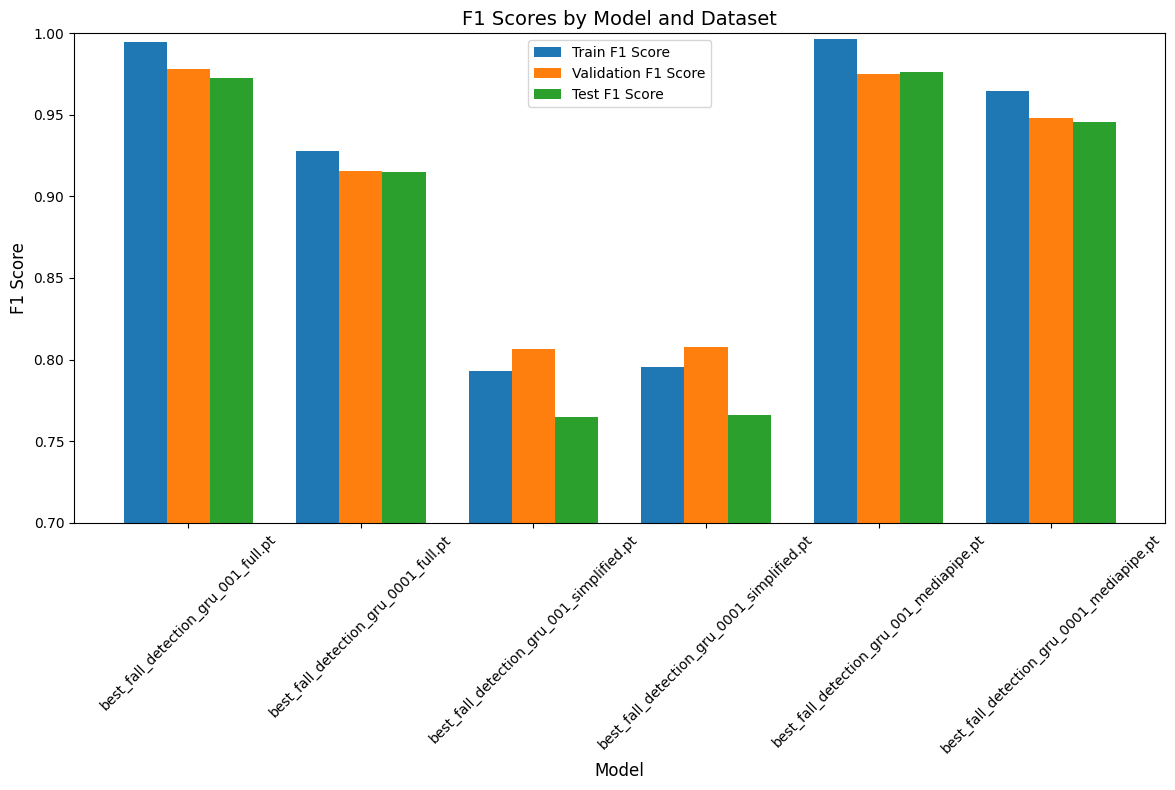

In [33]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [ ]:
# CNN 기반 낙상 감지 모델 정의
class FallDetectionCNN(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(FallDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, padding=1)  # mediapipe dataset을 공유하므로 in_channels은 22
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.transpose(1, 2)  # Conv1d의 형태를 맞추기 위함 (batch_size, channels, length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # tensor flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
# 모델 준비
def create_cnn_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence)  # CNN에서는 시퀀스 길이를 input size로 사용
        return FallDetectionCNN(input_size=input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 및 검증 설정
cnn_model_configs = [
    ('best_fall_detection_cnn_mediapipe_001.pt', 0.001),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.0001)
]

# 학습 파라미터 설정
num_epochs = 500
patience = 20

In [29]:
# 두 가지 학습률로 CNN 학습 진행
for cnn_model_name, learning_rate in cnn_model_configs:
    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0

    print(f"{cnn_model_name} 학습 시작 (lr={learning_rate})", flush=True)

    for epoch in range(num_epochs):
        model.train() # Training
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader_mediapipe, desc=f"Epoch {epoch + 1}/{num_epochs} (lr={learning_rate})"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss (lr={learning_rate}): {avg_loss_train:.4f}')

        model.eval() # Validation
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader_mediapipe:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss (lr={learning_rate}): {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), cnn_model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_cnn_mediapipe_001.pt 학습 시작 (lr=0.001)


Epoch 1/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.31it/s]


Epoch [1/500], Train Loss (lr=0.001): 0.5887
Epoch [1/500], Valid Loss (lr=0.001): 0.4677


Epoch 2/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 332.66it/s]


Epoch [2/500], Train Loss (lr=0.001): 0.4652
Epoch [2/500], Valid Loss (lr=0.001): 0.4410


Epoch 3/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.62it/s]


Epoch [3/500], Train Loss (lr=0.001): 0.4325
Epoch [3/500], Valid Loss (lr=0.001): 0.4279


Epoch 4/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.25it/s]


Epoch [4/500], Train Loss (lr=0.001): 0.4123
Epoch [4/500], Valid Loss (lr=0.001): 0.4057


Epoch 5/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 319.33it/s]


Epoch [5/500], Train Loss (lr=0.001): 0.3997
Epoch [5/500], Valid Loss (lr=0.001): 0.4128


Epoch 6/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.34it/s]


Epoch [6/500], Train Loss (lr=0.001): 0.3850
Epoch [6/500], Valid Loss (lr=0.001): 0.3836


Epoch 7/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.27it/s]


Epoch [7/500], Train Loss (lr=0.001): 0.3733
Epoch [7/500], Valid Loss (lr=0.001): 0.3767


Epoch 8/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.69it/s]


Epoch [8/500], Train Loss (lr=0.001): 0.3594
Epoch [8/500], Valid Loss (lr=0.001): 0.3812


Epoch 9/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 327.49it/s]


Epoch [9/500], Train Loss (lr=0.001): 0.3517
Epoch [9/500], Valid Loss (lr=0.001): 0.3771


Epoch 10/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.52it/s]


Epoch [10/500], Train Loss (lr=0.001): 0.3392
Epoch [10/500], Valid Loss (lr=0.001): 0.3393


Epoch 11/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 329.83it/s]


Epoch [11/500], Train Loss (lr=0.001): 0.3355
Epoch [11/500], Valid Loss (lr=0.001): 0.3684


Epoch 12/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.80it/s]


Epoch [12/500], Train Loss (lr=0.001): 0.3248
Epoch [12/500], Valid Loss (lr=0.001): 0.3259


Epoch 13/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 329.22it/s]


Epoch [13/500], Train Loss (lr=0.001): 0.3179
Epoch [13/500], Valid Loss (lr=0.001): 0.3517


Epoch 14/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 306.26it/s]


Epoch [14/500], Train Loss (lr=0.001): 0.3072
Epoch [14/500], Valid Loss (lr=0.001): 0.3153


Epoch 15/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.09it/s]


Epoch [15/500], Train Loss (lr=0.001): 0.3031
Epoch [15/500], Valid Loss (lr=0.001): 0.3152


Epoch 16/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 333.61it/s]


Epoch [16/500], Train Loss (lr=0.001): 0.2964
Epoch [16/500], Valid Loss (lr=0.001): 0.3326


Epoch 17/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 329.27it/s]


Epoch [17/500], Train Loss (lr=0.001): 0.2854
Epoch [17/500], Valid Loss (lr=0.001): 0.3079


Epoch 18/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.40it/s]


Epoch [18/500], Train Loss (lr=0.001): 0.2823
Epoch [18/500], Valid Loss (lr=0.001): 0.2915


Epoch 19/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.02it/s]


Epoch [19/500], Train Loss (lr=0.001): 0.2775
Epoch [19/500], Valid Loss (lr=0.001): 0.2816


Epoch 20/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 301.99it/s]


Epoch [20/500], Train Loss (lr=0.001): 0.2701
Epoch [20/500], Valid Loss (lr=0.001): 0.3092


Epoch 21/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 333.05it/s]


Epoch [21/500], Train Loss (lr=0.001): 0.2655
Epoch [21/500], Valid Loss (lr=0.001): 0.2656


Epoch 22/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.33it/s]


Epoch [22/500], Train Loss (lr=0.001): 0.2619
Epoch [22/500], Valid Loss (lr=0.001): 0.2669


Epoch 23/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.39it/s]


Epoch [23/500], Train Loss (lr=0.001): 0.2547
Epoch [23/500], Valid Loss (lr=0.001): 0.2709


Epoch 24/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.81it/s]


Epoch [24/500], Train Loss (lr=0.001): 0.2517
Epoch [24/500], Valid Loss (lr=0.001): 0.2700


Epoch 25/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.95it/s]


Epoch [25/500], Train Loss (lr=0.001): 0.2443
Epoch [25/500], Valid Loss (lr=0.001): 0.2488


Epoch 26/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.01it/s]


Epoch [26/500], Train Loss (lr=0.001): 0.2416
Epoch [26/500], Valid Loss (lr=0.001): 0.2809


Epoch 27/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 332.85it/s]


Epoch [27/500], Train Loss (lr=0.001): 0.2353
Epoch [27/500], Valid Loss (lr=0.001): 0.2661


Epoch 28/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.64it/s]


Epoch [28/500], Train Loss (lr=0.001): 0.2366
Epoch [28/500], Valid Loss (lr=0.001): 0.2527


Epoch 29/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 318.11it/s]


Epoch [29/500], Train Loss (lr=0.001): 0.2304
Epoch [29/500], Valid Loss (lr=0.001): 0.2589


Epoch 30/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 327.63it/s]


Epoch [30/500], Train Loss (lr=0.001): 0.2250
Epoch [30/500], Valid Loss (lr=0.001): 0.2656


Epoch 31/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.66it/s]


Epoch [31/500], Train Loss (lr=0.001): 0.2222
Epoch [31/500], Valid Loss (lr=0.001): 0.2610


Epoch 32/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.53it/s]


Epoch [32/500], Train Loss (lr=0.001): 0.1647
Epoch [32/500], Valid Loss (lr=0.001): 0.2141


Epoch 33/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.00it/s]


Epoch [33/500], Train Loss (lr=0.001): 0.1409
Epoch [33/500], Valid Loss (lr=0.001): 0.2163


Epoch 34/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.71it/s]


Epoch [34/500], Train Loss (lr=0.001): 0.1316
Epoch [34/500], Valid Loss (lr=0.001): 0.2189


Epoch 35/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.56it/s]


Epoch [35/500], Train Loss (lr=0.001): 0.1227
Epoch [35/500], Valid Loss (lr=0.001): 0.2264


Epoch 36/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 320.47it/s]


Epoch [36/500], Train Loss (lr=0.001): 0.1170
Epoch [36/500], Valid Loss (lr=0.001): 0.2208


Epoch 37/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 303.25it/s]


Epoch [37/500], Train Loss (lr=0.001): 0.1132
Epoch [37/500], Valid Loss (lr=0.001): 0.2273


Epoch 38/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 294.80it/s]


Epoch [38/500], Train Loss (lr=0.001): 0.1092
Epoch [38/500], Valid Loss (lr=0.001): 0.2283


Epoch 39/500 (lr=0.001): 100%|██████████| 1972/1972 [00:07<00:00, 269.24it/s]


Epoch [39/500], Train Loss (lr=0.001): 0.0998
Epoch [39/500], Valid Loss (lr=0.001): 0.2296


Epoch 40/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 302.68it/s]


Epoch [40/500], Train Loss (lr=0.001): 0.0972
Epoch [40/500], Valid Loss (lr=0.001): 0.2347


Epoch 41/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 302.47it/s]


Epoch [41/500], Train Loss (lr=0.001): 0.0968
Epoch [41/500], Valid Loss (lr=0.001): 0.2343


Epoch 42/500 (lr=0.001): 100%|██████████| 1972/1972 [00:07<00:00, 267.31it/s]


Epoch [42/500], Train Loss (lr=0.001): 0.0955
Epoch [42/500], Valid Loss (lr=0.001): 0.2382


Epoch 43/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 306.03it/s]


Epoch [43/500], Train Loss (lr=0.001): 0.0952
Epoch [43/500], Valid Loss (lr=0.001): 0.2393


Epoch 44/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 303.37it/s]


Epoch [44/500], Train Loss (lr=0.001): 0.0946
Epoch [44/500], Valid Loss (lr=0.001): 0.2423


Epoch 45/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 303.64it/s]


Epoch [45/500], Train Loss (lr=0.001): 0.0926
Epoch [45/500], Valid Loss (lr=0.001): 0.2422


Epoch 46/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 312.68it/s]


Epoch [46/500], Train Loss (lr=0.001): 0.0920
Epoch [46/500], Valid Loss (lr=0.001): 0.2425


Epoch 47/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 319.60it/s]


Epoch [47/500], Train Loss (lr=0.001): 0.0923
Epoch [47/500], Valid Loss (lr=0.001): 0.2427


Epoch 48/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 335.52it/s]


Epoch [48/500], Train Loss (lr=0.001): 0.0935
Epoch [48/500], Valid Loss (lr=0.001): 0.2428


Epoch 49/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 329.12it/s]


Epoch [49/500], Train Loss (lr=0.001): 0.0920
Epoch [49/500], Valid Loss (lr=0.001): 0.2430


Epoch 50/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 330.73it/s]


Epoch [50/500], Train Loss (lr=0.001): 0.0925
Epoch [50/500], Valid Loss (lr=0.001): 0.2431


Epoch 51/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 332.78it/s]


Epoch [51/500], Train Loss (lr=0.001): 0.0925
Epoch [51/500], Valid Loss (lr=0.001): 0.2431


Epoch 52/500 (lr=0.001): 100%|██████████| 1972/1972 [00:05<00:00, 332.68it/s]


Epoch [52/500], Train Loss (lr=0.001): 0.0925
Epoch [52/500], Valid Loss (lr=0.001): 0.2431
Early stopping
best_fall_detection_cnn_mediapipe_0001.pt 학습 시작 (lr=0.0001)


Epoch 1/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 339.40it/s]


Epoch [1/500], Train Loss (lr=0.0001): 0.7156
Epoch [1/500], Valid Loss (lr=0.0001): 0.5804


Epoch 2/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 331.54it/s]


Epoch [2/500], Train Loss (lr=0.0001): 0.5247
Epoch [2/500], Valid Loss (lr=0.0001): 0.4773


Epoch 3/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.17it/s]


Epoch [3/500], Train Loss (lr=0.0001): 0.4817
Epoch [3/500], Valid Loss (lr=0.0001): 0.4583


Epoch 4/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 336.38it/s]


Epoch [4/500], Train Loss (lr=0.0001): 0.4553
Epoch [4/500], Valid Loss (lr=0.0001): 0.4401


Epoch 5/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.03it/s]


Epoch [5/500], Train Loss (lr=0.0001): 0.4351
Epoch [5/500], Valid Loss (lr=0.0001): 0.4504


Epoch 6/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.86it/s]


Epoch [6/500], Train Loss (lr=0.0001): 0.4188
Epoch [6/500], Valid Loss (lr=0.0001): 0.4137


Epoch 7/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.17it/s]


Epoch [7/500], Train Loss (lr=0.0001): 0.4036
Epoch [7/500], Valid Loss (lr=0.0001): 0.3971


Epoch 8/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.30it/s]


Epoch [8/500], Train Loss (lr=0.0001): 0.3939
Epoch [8/500], Valid Loss (lr=0.0001): 0.3934


Epoch 9/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.48it/s]


Epoch [9/500], Train Loss (lr=0.0001): 0.3815
Epoch [9/500], Valid Loss (lr=0.0001): 0.3895


Epoch 10/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.21it/s]


Epoch [10/500], Train Loss (lr=0.0001): 0.3713
Epoch [10/500], Valid Loss (lr=0.0001): 0.3752


Epoch 11/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.78it/s]


Epoch [11/500], Train Loss (lr=0.0001): 0.3658
Epoch [11/500], Valid Loss (lr=0.0001): 0.3685


Epoch 12/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.67it/s]


Epoch [12/500], Train Loss (lr=0.0001): 0.3556
Epoch [12/500], Valid Loss (lr=0.0001): 0.3736


Epoch 13/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.67it/s]


Epoch [13/500], Train Loss (lr=0.0001): 0.3480
Epoch [13/500], Valid Loss (lr=0.0001): 0.3594


Epoch 14/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.33it/s]


Epoch [14/500], Train Loss (lr=0.0001): 0.3404
Epoch [14/500], Valid Loss (lr=0.0001): 0.3488


Epoch 15/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.28it/s]


Epoch [15/500], Train Loss (lr=0.0001): 0.3332
Epoch [15/500], Valid Loss (lr=0.0001): 0.3393


Epoch 16/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.43it/s]


Epoch [16/500], Train Loss (lr=0.0001): 0.3240
Epoch [16/500], Valid Loss (lr=0.0001): 0.3569


Epoch 17/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 331.99it/s]


Epoch [17/500], Train Loss (lr=0.0001): 0.3194
Epoch [17/500], Valid Loss (lr=0.0001): 0.3241


Epoch 18/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 335.14it/s]


Epoch [18/500], Train Loss (lr=0.0001): 0.3111
Epoch [18/500], Valid Loss (lr=0.0001): 0.3237


Epoch 19/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.41it/s]


Epoch [19/500], Train Loss (lr=0.0001): 0.3023
Epoch [19/500], Valid Loss (lr=0.0001): 0.3029


Epoch 20/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 337.12it/s]


Epoch [20/500], Train Loss (lr=0.0001): 0.2967
Epoch [20/500], Valid Loss (lr=0.0001): 0.3102


Epoch 21/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.65it/s]


Epoch [21/500], Train Loss (lr=0.0001): 0.2905
Epoch [21/500], Valid Loss (lr=0.0001): 0.3179


Epoch 22/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 335.54it/s]


Epoch [22/500], Train Loss (lr=0.0001): 0.2825
Epoch [22/500], Valid Loss (lr=0.0001): 0.3006


Epoch 23/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.01it/s]


Epoch [23/500], Train Loss (lr=0.0001): 0.2758
Epoch [23/500], Valid Loss (lr=0.0001): 0.2958


Epoch 24/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 330.90it/s]


Epoch [24/500], Train Loss (lr=0.0001): 0.2708
Epoch [24/500], Valid Loss (lr=0.0001): 0.2918


Epoch 25/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 336.62it/s]


Epoch [25/500], Train Loss (lr=0.0001): 0.2617
Epoch [25/500], Valid Loss (lr=0.0001): 0.2854


Epoch 26/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 330.82it/s]


Epoch [26/500], Train Loss (lr=0.0001): 0.2607
Epoch [26/500], Valid Loss (lr=0.0001): 0.2890


Epoch 27/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.07it/s]


Epoch [27/500], Train Loss (lr=0.0001): 0.2513
Epoch [27/500], Valid Loss (lr=0.0001): 0.2760


Epoch 28/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.73it/s]


Epoch [28/500], Train Loss (lr=0.0001): 0.2496
Epoch [28/500], Valid Loss (lr=0.0001): 0.2658


Epoch 29/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.94it/s]


Epoch [29/500], Train Loss (lr=0.0001): 0.2402
Epoch [29/500], Valid Loss (lr=0.0001): 0.2615


Epoch 30/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 335.19it/s]


Epoch [30/500], Train Loss (lr=0.0001): 0.2342
Epoch [30/500], Valid Loss (lr=0.0001): 0.3090


Epoch 31/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.84it/s]


Epoch [31/500], Train Loss (lr=0.0001): 0.2308
Epoch [31/500], Valid Loss (lr=0.0001): 0.2546


Epoch 32/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.73it/s]


Epoch [32/500], Train Loss (lr=0.0001): 0.2234
Epoch [32/500], Valid Loss (lr=0.0001): 0.2481


Epoch 33/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.12it/s]


Epoch [33/500], Train Loss (lr=0.0001): 0.2171
Epoch [33/500], Valid Loss (lr=0.0001): 0.2512


Epoch 34/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 336.94it/s]


Epoch [34/500], Train Loss (lr=0.0001): 0.2131
Epoch [34/500], Valid Loss (lr=0.0001): 0.2474


Epoch 35/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 335.18it/s]


Epoch [35/500], Train Loss (lr=0.0001): 0.2090
Epoch [35/500], Valid Loss (lr=0.0001): 0.2497


Epoch 36/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.74it/s]


Epoch [36/500], Train Loss (lr=0.0001): 0.2080
Epoch [36/500], Valid Loss (lr=0.0001): 0.2244


Epoch 37/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.32it/s]


Epoch [37/500], Train Loss (lr=0.0001): 0.2002
Epoch [37/500], Valid Loss (lr=0.0001): 0.2250


Epoch 38/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 336.11it/s]


Epoch [38/500], Train Loss (lr=0.0001): 0.1955
Epoch [38/500], Valid Loss (lr=0.0001): 0.2458


Epoch 39/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.75it/s]


Epoch [39/500], Train Loss (lr=0.0001): 0.1927
Epoch [39/500], Valid Loss (lr=0.0001): 0.2335


Epoch 40/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 337.10it/s]


Epoch [40/500], Train Loss (lr=0.0001): 0.1812
Epoch [40/500], Valid Loss (lr=0.0001): 0.2381


Epoch 41/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.33it/s]


Epoch [41/500], Train Loss (lr=0.0001): 0.1826
Epoch [41/500], Valid Loss (lr=0.0001): 0.2258


Epoch 42/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 331.52it/s]


Epoch [42/500], Train Loss (lr=0.0001): 0.1774
Epoch [42/500], Valid Loss (lr=0.0001): 0.2144


Epoch 43/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.20it/s]


Epoch [43/500], Train Loss (lr=0.0001): 0.1705
Epoch [43/500], Valid Loss (lr=0.0001): 0.2159


Epoch 44/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.46it/s]


Epoch [44/500], Train Loss (lr=0.0001): 0.1686
Epoch [44/500], Valid Loss (lr=0.0001): 0.2142


Epoch 45/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.28it/s]


Epoch [45/500], Train Loss (lr=0.0001): 0.1644
Epoch [45/500], Valid Loss (lr=0.0001): 0.2064


Epoch 46/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 318.94it/s]


Epoch [46/500], Train Loss (lr=0.0001): 0.1597
Epoch [46/500], Valid Loss (lr=0.0001): 0.2176


Epoch 47/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 318.57it/s]


Epoch [47/500], Train Loss (lr=0.0001): 0.1548
Epoch [47/500], Valid Loss (lr=0.0001): 0.2058


Epoch 48/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.50it/s]


Epoch [48/500], Train Loss (lr=0.0001): 0.1507
Epoch [48/500], Valid Loss (lr=0.0001): 0.2110


Epoch 49/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.32it/s]


Epoch [49/500], Train Loss (lr=0.0001): 0.1493
Epoch [49/500], Valid Loss (lr=0.0001): 0.2126


Epoch 50/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.04it/s]


Epoch [50/500], Train Loss (lr=0.0001): 0.1453
Epoch [50/500], Valid Loss (lr=0.0001): 0.1987


Epoch 51/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.05it/s]


Epoch [51/500], Train Loss (lr=0.0001): 0.1410
Epoch [51/500], Valid Loss (lr=0.0001): 0.2074


Epoch 52/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 331.32it/s]


Epoch [52/500], Train Loss (lr=0.0001): 0.1391
Epoch [52/500], Valid Loss (lr=0.0001): 0.2034


Epoch 53/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 339.70it/s]


Epoch [53/500], Train Loss (lr=0.0001): 0.1355
Epoch [53/500], Valid Loss (lr=0.0001): 0.2038


Epoch 54/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.69it/s]


Epoch [54/500], Train Loss (lr=0.0001): 0.1333
Epoch [54/500], Valid Loss (lr=0.0001): 0.2011


Epoch 55/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 334.40it/s]


Epoch [55/500], Train Loss (lr=0.0001): 0.1275
Epoch [55/500], Valid Loss (lr=0.0001): 0.2032


Epoch 56/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 328.88it/s]


Epoch [56/500], Train Loss (lr=0.0001): 0.1334
Epoch [56/500], Valid Loss (lr=0.0001): 0.2006


Epoch 57/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.20it/s]


Epoch [57/500], Train Loss (lr=0.0001): 0.0917
Epoch [57/500], Valid Loss (lr=0.0001): 0.1809


Epoch 58/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 335.34it/s]


Epoch [58/500], Train Loss (lr=0.0001): 0.0799
Epoch [58/500], Valid Loss (lr=0.0001): 0.1801


Epoch 59/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.11it/s]


Epoch [59/500], Train Loss (lr=0.0001): 0.0765
Epoch [59/500], Valid Loss (lr=0.0001): 0.1840


Epoch 60/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.54it/s]


Epoch [60/500], Train Loss (lr=0.0001): 0.0745
Epoch [60/500], Valid Loss (lr=0.0001): 0.1857


Epoch 61/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.42it/s]


Epoch [61/500], Train Loss (lr=0.0001): 0.0723
Epoch [61/500], Valid Loss (lr=0.0001): 0.1878


Epoch 62/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 336.07it/s]


Epoch [62/500], Train Loss (lr=0.0001): 0.0699
Epoch [62/500], Valid Loss (lr=0.0001): 0.1858


Epoch 63/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 330.64it/s]


Epoch [63/500], Train Loss (lr=0.0001): 0.0686
Epoch [63/500], Valid Loss (lr=0.0001): 0.1899


Epoch 64/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.62it/s]


Epoch [64/500], Train Loss (lr=0.0001): 0.0675
Epoch [64/500], Valid Loss (lr=0.0001): 0.1840


Epoch 65/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 340.53it/s]


Epoch [65/500], Train Loss (lr=0.0001): 0.0634
Epoch [65/500], Valid Loss (lr=0.0001): 0.1881


Epoch 66/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 330.37it/s]


Epoch [66/500], Train Loss (lr=0.0001): 0.0629
Epoch [66/500], Valid Loss (lr=0.0001): 0.1875


Epoch 67/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 329.96it/s]


Epoch [67/500], Train Loss (lr=0.0001): 0.0629
Epoch [67/500], Valid Loss (lr=0.0001): 0.1886


Epoch 68/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 337.76it/s]


Epoch [68/500], Train Loss (lr=0.0001): 0.0622
Epoch [68/500], Valid Loss (lr=0.0001): 0.1904


Epoch 69/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 339.35it/s]


Epoch [69/500], Train Loss (lr=0.0001): 0.0620
Epoch [69/500], Valid Loss (lr=0.0001): 0.1890


Epoch 70/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 330.04it/s]


Epoch [70/500], Train Loss (lr=0.0001): 0.0623
Epoch [70/500], Valid Loss (lr=0.0001): 0.1897


Epoch 71/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.15it/s]


Epoch [71/500], Train Loss (lr=0.0001): 0.0623
Epoch [71/500], Valid Loss (lr=0.0001): 0.1900


Epoch 72/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 331.08it/s]


Epoch [72/500], Train Loss (lr=0.0001): 0.0617
Epoch [72/500], Valid Loss (lr=0.0001): 0.1902


Epoch 73/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 333.49it/s]


Epoch [73/500], Train Loss (lr=0.0001): 0.0611
Epoch [73/500], Valid Loss (lr=0.0001): 0.1902


Epoch 74/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 340.17it/s]


Epoch [74/500], Train Loss (lr=0.0001): 0.0621
Epoch [74/500], Valid Loss (lr=0.0001): 0.1903


Epoch 75/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.63it/s]


Epoch [75/500], Train Loss (lr=0.0001): 0.0615
Epoch [75/500], Valid Loss (lr=0.0001): 0.1903


Epoch 76/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 328.87it/s]


Epoch [76/500], Train Loss (lr=0.0001): 0.0618
Epoch [76/500], Valid Loss (lr=0.0001): 0.1903


Epoch 77/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 332.88it/s]


Epoch [77/500], Train Loss (lr=0.0001): 0.0614
Epoch [77/500], Valid Loss (lr=0.0001): 0.1903


Epoch 78/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.10it/s]


Epoch [78/500], Train Loss (lr=0.0001): 0.0615
Epoch [78/500], Valid Loss (lr=0.0001): 0.1902
Early stopping


In [34]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for cnn_model_name, _ in cnn_model_configs:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.load_state_dict(torch.load(cnn_model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': cnn_model_name}
    for loader_name, data_loader in [('Train', train_loader_mediapipe), ('Validation', valid_loader_mediapipe), ('Test', test_loader_mediapipe)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{cnn_model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

best_fall_detection_cnn_mediapipe_001.pt (Train): F1 Score: 0.9531
Confusion Matrix (Train):
[[34439  1505   517]
 [  135  4607   126]
 [  188   651 20931]]
best_fall_detection_cnn_mediapipe_001.pt (Validation): F1 Score: 0.9386
Confusion Matrix (Validation):
[[6413  313  154]
 [  63  921   33]
 [ 102  135 4372]]
best_fall_detection_cnn_mediapipe_001.pt (Test): F1 Score: 0.9337
Confusion Matrix (Test):
[[7253  423  188]
 [  44  861   37]
 [  66  155 3877]]
best_fall_detection_cnn_mediapipe_0001.pt (Train): F1 Score: 0.9740
Confusion Matrix (Train):
[[35245  1014   202]
 [   29  4828    11]
 [   70   390 21310]]
best_fall_detection_cnn_mediapipe_0001.pt (Validation): F1 Score: 0.9580
Confusion Matrix (Validation):
[[6575  214   91]
 [  42  955   20]
 [  80   94 4435]]
best_fall_detection_cnn_mediapipe_0001.pt (Test): F1 Score: 0.9576
Confusion Matrix (Test):
[[7459  278  127]
 [  31  888   23]
 [  34   78 3986]]


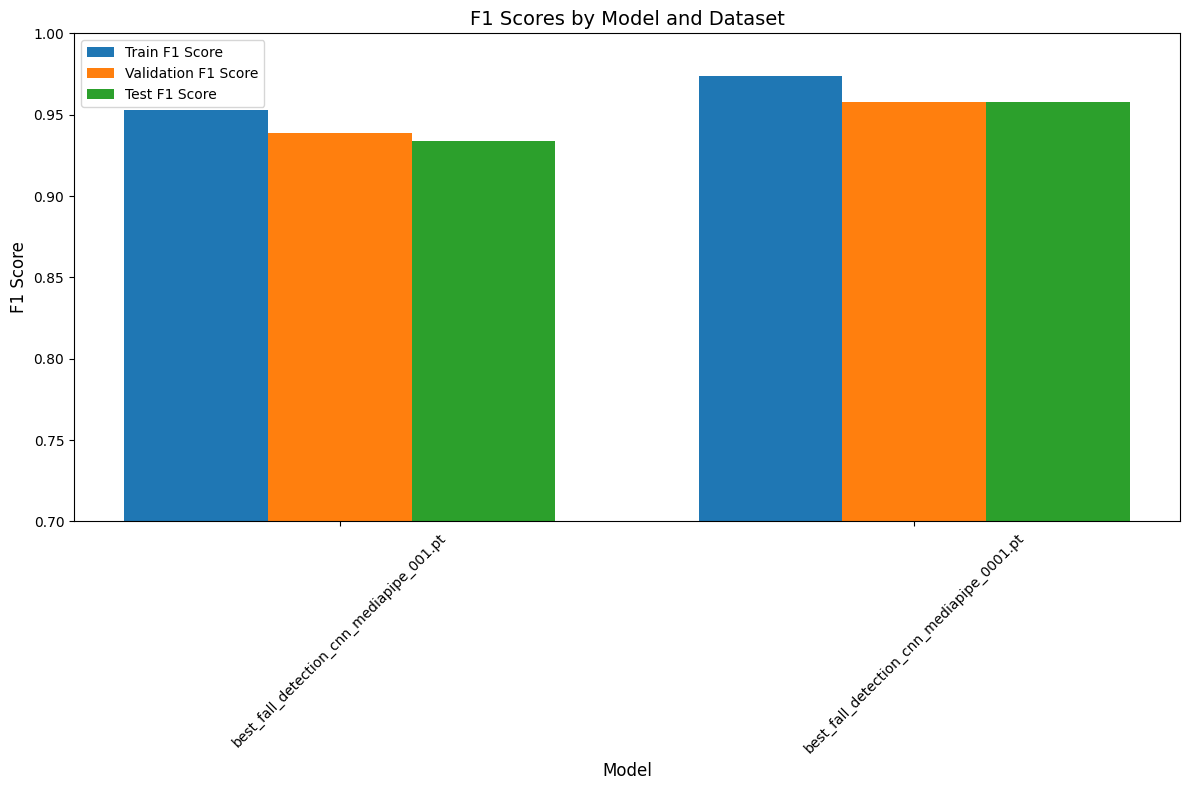

In [36]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

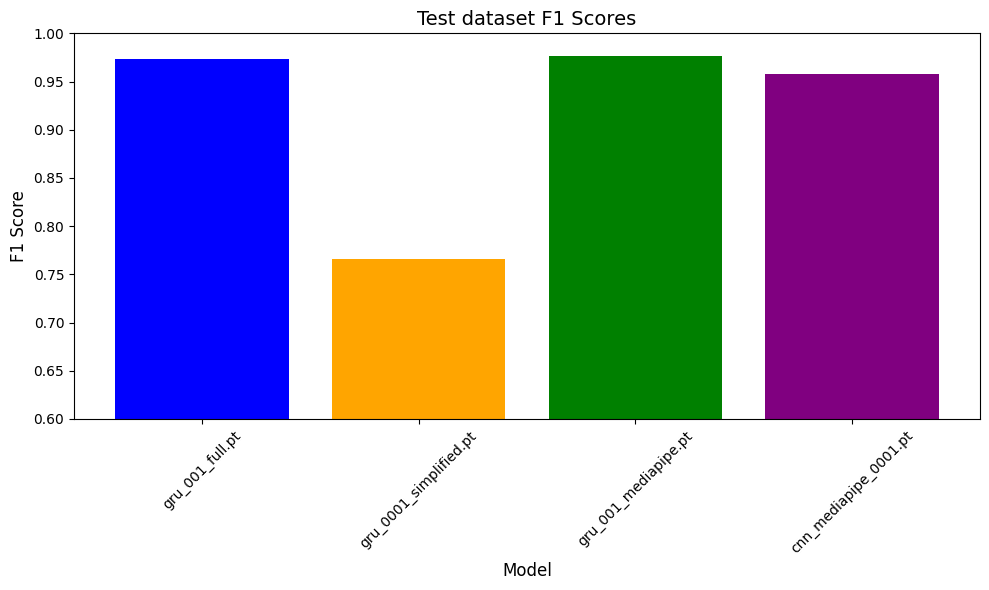

In [41]:
model_f1_scores = [
    ('best_fall_detection_gru_001_full.pt', 0.9729),
    ('best_fall_detection_gru_0001_simplified.pt', 0.7662),
    ('best_fall_detection_gru_001_mediapipe.pt', 0.9761),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.9576)
]

# 모델명과 Test F1 Scores를 분리하여 리스트로 저장
model_names = [name.split('best_fall_detection_')[1] for name, _ in model_f1_scores]
train_f1_scores = [x[1] for x in model_f1_scores]

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_f1_scores, color=['blue', 'orange', 'green', 'purple'])

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Test dataset F1 Scores", fontsize=14)
plt.ylim(0.6, 1.0)

# x축 라벨의 가독성을 위해 회전 추가
plt.xticks(rotation=45, fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()